# <span style='font-family:"Times New Roman"'> <span styel=''>**WHOLE GENOME DOUBLING ANALYSIS**

*Emile Cohen*
    
 *May 2020*

**Goal:** In this notebook, we analyse all MSK-Imoact Cohort to know the proportion of WGD Samples, the tp53 mutated samples. Then we output a diagram with important information.

This is the first discovery of the cohort, allowing to filter out the non-interesting samples. In the last section **Saving different cohort files**, we are able to save the 4 files for the 2 cohort we wanna create (WGD and Non-WGD), then the script **master_creation** takes these files as input and compute the master file.

---

In [36]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

# MSK-Impact Cohort

## Size

In [107]:
# Loading the data
maf_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.ccf.maf', sep='\t')
annotated_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.cohort.txt', sep='\t')
arm_level = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.arm_level.txt', sep='\t')
gene_level = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.gene_level_grepTP53.txt', sep='\t')

In [108]:
# First we need to create a sample_mut_key to identify duplicated mutations
maf_cohort['mut_key'] = maf_cohort.apply(lambda h: str(h.Chromosome)+'_'+str(h.Start_Position)+'_'+str(h.Reference_Allele)+'_'+str(h.Tumor_Seq_Allele2), axis=1)  
maf_cohort['sample_mut_key'] = maf_cohort.apply(lambda h: h.Tumor_Sample_Barcode + '-' + h.mut_key, axis = 1)

The following cell shows the size of the total cohort through the different input files. We see that the cohort is more than 40 000 samples but only 38 465 have mutational information.

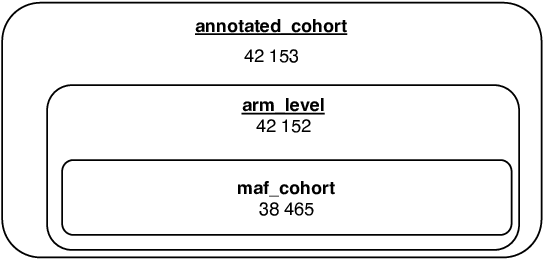

In [3]:
img = WImage(filename='total_cohort.pdf', resolution=150)
img

## WGD column
The annotated_cohort have a column called *wgd*. On the other side, for the TP53 mutated cohort, we computed the WGD states by hand. Let's see if the WGD column is accurate.

In [4]:
#Loading the master_file
master = pd.read_pickle(data_path + 'merged_data/master_file.pkl')
#master = master[['Tumor_Id', 'wgd']]

In [5]:
annotated_cohort_wgd = annotated_cohort[['tumor_sample', 'wgd']]

In [6]:
# left merge 
merged = pd.merge(left=master, right=annotated_cohort_wgd, how='left', left_on='Tumor_Id', right_on='tumor_sample')
merged.head()

,Sample_Id,Tumor_Id,Patient_Id,Cancer_Type,Cancer_Type_Detailed,Sample_Type,purity,ploidy,samples_per_patient,Overall Survival Status,Overall Survival (Months),MSI Score,TMB_Score,Patient_Current_Age,Sex,Ethnicity_Category,Race_Category,mutationStatus,Somatic_Status,tp53_key_1,tp53_vc_1,tp53_ccf_1,tp53_vaf_1,tp53_HGVSp_1,tp53_spot_1,tp53_key_2,tp53_vc_2,tp53_ccf_2,tp53_vaf_2,tp53_HGVSp_2,tp53_spot_2,tp53_key_3,tp53_vc_3,tp53_ccf_3,tp53_vaf_3,tp53_HGVSp_3,tp53_spot_3,tp53_key_4,tp53_vc_4,tp53_ccf_4,tp53_vaf_4,tp53_HGVSp_4,tp53_spot_4,tp53_key_5,tp53_vc_5,tp53_ccf_5,tp53_vaf_5,tp53_HGVSp_5,tp53_spot_5,tp53_count,tp53_tcn,tp53_mcn,tp53_lcn,tp53_seg_length,tp53_cn_state,tp53_cf,wgd_x,mutation_count,gene_count,driver_count,max_vaf,tp53_exp_nb_1,tp53_exp_nb_2,tp53_exp_nb_3,tp53_exp_nb_4,tp53_exp_nb_5,tp53_residual_1,tp53_residual_2,tp53_residual_3,tp53_residual_4,tp53_residual_5,tp53_first_group,tp53_group,tp53_res_group,chr_affected,chr_loss,chr_gain,chr_cnloh,frac_genome_altered,tp53_vc_group_1,tp53_vc_group_2,tp53_vc_group_3,tp53_vc_group_4,tp53_vc_group_5,tumor_sample,wgd_y
0,P-0034223-T01-IM6_P-0034223-N01-IM6,P-0034223-T01-IM6,P-0034223,Breast Cancer,Invasive Breast Carcinoma,Metastasis,0.941111,2.241830,1.0,LIVING,NaN,0.55,5.3,63.0,Female,NaN,NO VALUE ENTERED,SOMATIC,Matched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2.0,1.0,1.0,80668592.0,DIPLOID,1.000000,-1,6,6.0,0,0.901899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WILD_TYPE,None,None,3,2,2,0,0.08,None,None,None,None,None,P-0034223-T01-IM6,False
1,P-0009819-T01-IM5_P-0009819-N01-IM5,P-0009819-T01-IM5,P-0009819,Prostate Cancer,Prostate Adenocarcinoma,Primary,0.275237,2.681075,1.0,LIVING,23.441,0.00,1.0,72.0,Male,Non-Spanish; Non-Hispanic,NO VALUE ENTERED,SOMATIC,Matched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2.0,1.0,1.0,80668300.0,DIPLOID,1.000000,-1,1,1.0,0,0.148014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WILD_TYPE,None,None,4,4,0,0,0.137,None,None,None,None,None,P-0009819-T01-IM5,False
2,P-0025956-T01-IM6_P-0025956-N01-IM6,P-0025956-T01-IM6,P-0025956,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,Primary,0.185874,3.496971,1.0,DECEASED,3.584,0.00,5.3,71.0,Female,Non-Spanish; Non-Hispanic,WHITE,SOMATIC,Matched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,3.0,2.0,1.0,80668431.0,LOSS AFTER,0.169170,1,6,6.0,0,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WILD_TYPE,None,None,13,13,1,1,0.624,None,None,None,None,None,P-0025956-T01-IM6,True
3,P-0027408-T01-IM6_P-0027408-N01-IM6,P-0027408-T01-IM6,P-0027408,Non-Small Cell Lung Cancer,Non-Small Cell Lung Cancer,Metastasis,0.308886,1.811066,1.0,LIVING,22.586,0.27,17.6,67.0,Female,Non-Spanish; Non-Hispanic,WHITE,SOMATIC,Matched,P-0027408-T01-IM617_7578409_CT_TC,Missense_Mutation,0.925,0.168901,p.Arg174Glu,174,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,1,1.0,1.0,0.0,26256025.0,HETLOSS,0.275073,-1,20,18.0,0,0.192475,0.924711,NaN,NaN,NaN,NaN,0.075289,NaN,NaN,NaN,NaN,LOSS,>=1_LOSS,no_tp53_res,12,11,3,0,0.444,missense,None,None,None,None,P-0027408-T01-IM6,False
4,P-0006554-T01-IM5_P-0006554-N01-IM5,P-0006554-T01-IM5,P-0006554,Glioma,Anaplastic Oligodendroglioma,Primary,0.715208,1.910719,1.0,LIVING,26.170,1.30,46.2,55.0,Female,Non-Spanish; Non-Hispanic,WHITE,SOMATIC,Matched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2.0,1.0,1.0,40254480.0,DIPLOID,1.000000,-1,47,39.0,0,0.706897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WILD_TYPE,None,None,5,4,1,0,0.173,None,None,None,None,None,P-0006554-T01-IM5,False


In [7]:
len(set(annotated_cohort[annotated_cohort['purity'] >= 0.2].tumor_sample))

34491

Now the idea is to compare *wgd_x* and *wgd_y* to see if there are inconsistencies.

In [8]:
# We define a function to create a new column
def check_inconsistencies(x):
    if (x.wgd_x == 1 and x.wgd_y == True) or (x.wgd_x == -1 and x.wgd_y == False):
        return 0
    else: return 1
    
merged['inconsistencies'] = merged.apply(check_inconsistencies, axis=1)

In [9]:
# now we sum the inconsistencies column to see if we have any inconsistency. We should have 0 for no inconsitencies at all.
merged.inconsistencies.sum()

9

So we have 121 samples with problems: let's take a look.

In [10]:
merged[merged['inconsistencies'] == 1][~merged.wgd_y.isna()]

,Sample_Id,Tumor_Id,Patient_Id,Cancer_Type,Cancer_Type_Detailed,Sample_Type,purity,ploidy,samples_per_patient,Overall Survival Status,Overall Survival (Months),MSI Score,TMB_Score,Patient_Current_Age,Sex,Ethnicity_Category,Race_Category,mutationStatus,Somatic_Status,tp53_key_1,tp53_vc_1,tp53_ccf_1,tp53_vaf_1,tp53_HGVSp_1,tp53_spot_1,tp53_key_2,tp53_vc_2,tp53_ccf_2,tp53_vaf_2,tp53_HGVSp_2,tp53_spot_2,tp53_key_3,tp53_vc_3,tp53_ccf_3,tp53_vaf_3,tp53_HGVSp_3,tp53_spot_3,tp53_key_4,tp53_vc_4,tp53_ccf_4,tp53_vaf_4,tp53_HGVSp_4,tp53_spot_4,tp53_key_5,tp53_vc_5,tp53_ccf_5,tp53_vaf_5,tp53_HGVSp_5,tp53_spot_5,tp53_count,tp53_tcn,tp53_mcn,tp53_lcn,tp53_seg_length,tp53_cn_state,tp53_cf,wgd_x,mutation_count,gene_count,driver_count,max_vaf,tp53_exp_nb_1,tp53_exp_nb_2,tp53_exp_nb_3,tp53_exp_nb_4,tp53_exp_nb_5,tp53_residual_1,tp53_residual_2,tp53_residual_3,tp53_residual_4,tp53_residual_5,tp53_first_group,tp53_group,tp53_res_group,chr_affected,chr_loss,chr_gain,chr_cnloh,frac_genome_altered,tp53_vc_group_1,tp53_vc_group_2,tp53_vc_group_3,tp53_vc_group_4,tp53_vc_group_5,tumor_sample,wgd_y,inconsistencies
2592,P-0011205-T03-IM6_P-0011205-N01-IM6,P-0011205-T03-IM6,P-0011205,Hepatobiliary Cancer,Hepatoblastoma,Metastasis,0.597227,2.558590,4.0,DECEASED,28.471,0.22,3.5,18.0,Male,Non-Spanish; Non-Hispanic,WHITE,SOMATIC,Matched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2.0,1.0,1.0,43252132.0,DIPLOID,1.000000,-1,4,4.0,0,0.456522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WILD_TYPE,None,None,4,1,3,0,0.23,None,None,None,None,None,P-0011205-T03-IM6,True,1
4189,P-0020803-T02-IM6_P-0020803-N01-IM6,P-0020803-T02-IM6,P-0020803,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,Metastasis,0.215883,2.132073,3.0,LIVING,30.148,0.00,6.1,65.0,Female,Non-Spanish; Non-Hispanic,WHITE,SOMATIC,Matched,P-0020803-T02-IM617_7579591_C_A,Splice_Site,1.0,0.149621,nan,nan,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,1,2.0,2.0,0.0,80668481.0,CNLOH,0.183877,-1,7,7.0,2,0.172007,1.386134,NaN,NaN,NaN,NaN,0.613866,NaN,NaN,NaN,NaN,cnLOH,>=1_cnLOH,no_tp53_res,11,9,0,2,0.584,truncated,None,None,None,None,P-0020803-T02-IM6,True,1
6140,P-0022193-T02-IM6_P-0022193-N01-IM6,P-0022193-T02-IM6,P-0022193,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,Primary,0.312344,1.796592,3.0,LIVING,30.444,0.12,0.9,72.0,Female,"Spanish NOS; Hispanic NOS, Latino NOS",WHITE,SOMATIC,Matched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2.0,1.0,1.0,74618734.0,DIPLOID,1.000000,-1,1,1.0,0,0.186364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WILD_TYPE,None,None,9,7,1,1,0.379,None,None,None,None,None,P-0022193-T02-IM6,True,1
11503,P-0016952-T02-IM6_P-0016952-N01-IM6,P-0016952-T02-IM6,P-0016952,Breast Cancer,Invasive Breast Carcinoma,Metastasis,0.663832,1.880965,3.0,DECEASED,23.211,0.16,2.6,39.0,Female,Non-Spanish; Non-Hispanic,WHITE,SOMATIC,Matched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,1.0,1.0,0.0,17016881.0,HETLOSS,0.663736,-1,3,3.0,1,0.359869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOSS,0_HETLOSS,tp53_res,8,8,2,1,0.343,None,None,None,None,None,P-0016952-T02-IM6,True,1
20336,P-0005192-T01-IM5_P-0005192-N01-IM5,P-0005192-T01-IM5,P-0005192,Histiocytosis,Histiocytic and Dendritic Cell Neoplasms,Primary,0.552451,4.305652,2.0,LIVING,56.712,13.38,8.9,35.0,Male,NaN,WHITE,UNKNOWN,Unmatched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,6.0,3.0,3.0,38452166.0,AMP (BALANCED),0.368602,-1,9,7.0,4,0.519380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OTHER,None,None,20,0,17,0,0.989,None,None,None,None,None,P-0005192-T01-IM5,True,1
21260,P-0018318-T01-IM6_P-0018318-N01-IM6,P-0018318-T01-I

We see that those inconsistencies come from the fact that some tumor samples have different Normal matched with one of them being with a WGD. They annotate the sample as a WGD sample.

So let's filter annotated_cohort - keep the highest purity matched normal - and see if the inconsistencies are still present.

In [11]:
def normal_samp_duplicates_filter(df, sample_name, purity_name):
    '''
    This function aims to filter out the samples that have the same tumor id but different normal samples.
    We choose to keep only the one with the highest purity in case of duplicates.
    
    Arguments:
        - df: the dataframe we want to clean
        - sample_name: the name of the column containing the sample. Ex: P-0006554-T01-IM5_P-0006554-N01-IM5
        - purity_name: the name of the column containing the purity
    '''
    
    # We first restrain to the interesting columns
    sub_df = df[[sample_name, purity_name]]
    #Create the column with the tumor_id and set it as index to identify the duplicates
    sub_df['Tumor_Id'] = sub_df[sample_name].str[:17]
    sub_df = sub_df.set_index('Tumor_Id')
    # We use the duplicated() method to create a False/True Series if the sample is duplicated
    duplicates_series = sub_df[sample_name].str[:17].duplicated()
    # We then select only samples that are duplicated to obtain the list of duplicated samples
    duplicated_samples = list(duplicates_series[duplicates_series == True].index)

    # We put the sample_name column as Index
    sub_df = sub_df.set_index(sample_name)

    # We can now filter out the samples that are listed in duplicated_samples
    to_be_filtered = []
    for sample in duplicated_samples:
        to_be_filtered.append(sub_df[sub_df.index.str[:17] == sample][['purity']].idxmin()['purity'])
    
    #print(to_be_filtered)
    # Now we filter out the lines that are in the list
    df = df[~df[sample_name].isin(to_be_filtered)]
    
    return df

In [12]:
annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort, 'sample_id', 'purity')
annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort_filt, 'sample_id', 'purity')
# the last duplicated samples are samples with purity = NaN so we simply use deplicated method
annotated_cohort_filt = annotated_cohort_filt.drop_duplicates(subset='tumor_sample')

In [13]:
annotated_cohort_wgd = annotated_cohort_filt[['tumor_sample', 'wgd']]
merged = pd.merge(left=master, right=annotated_cohort_wgd, how='left', left_on='Tumor_Id', right_on='tumor_sample')
merged['inconsistencies'] = merged.apply(check_inconsistencies, axis=1)
merged[merged['inconsistencies'] == 1]#[~merged.wgd_y.isna()]

,Sample_Id,Tumor_Id,Patient_Id,Cancer_Type,Cancer_Type_Detailed,Sample_Type,purity,ploidy,samples_per_patient,Overall Survival Status,Overall Survival (Months),MSI Score,TMB_Score,Patient_Current_Age,Sex,Ethnicity_Category,Race_Category,mutationStatus,Somatic_Status,tp53_key_1,tp53_vc_1,tp53_ccf_1,tp53_vaf_1,tp53_HGVSp_1,tp53_spot_1,tp53_key_2,tp53_vc_2,tp53_ccf_2,tp53_vaf_2,tp53_HGVSp_2,tp53_spot_2,tp53_key_3,tp53_vc_3,tp53_ccf_3,tp53_vaf_3,tp53_HGVSp_3,tp53_spot_3,tp53_key_4,tp53_vc_4,tp53_ccf_4,tp53_vaf_4,tp53_HGVSp_4,tp53_spot_4,tp53_key_5,tp53_vc_5,tp53_ccf_5,tp53_vaf_5,tp53_HGVSp_5,tp53_spot_5,tp53_count,tp53_tcn,tp53_mcn,tp53_lcn,tp53_seg_length,tp53_cn_state,tp53_cf,wgd_x,mutation_count,gene_count,driver_count,max_vaf,tp53_exp_nb_1,tp53_exp_nb_2,tp53_exp_nb_3,tp53_exp_nb_4,tp53_exp_nb_5,tp53_residual_1,tp53_residual_2,tp53_residual_3,tp53_residual_4,tp53_residual_5,tp53_first_group,tp53_group,tp53_res_group,chr_affected,chr_loss,chr_gain,chr_cnloh,frac_genome_altered,tp53_vc_group_1,tp53_vc_group_2,tp53_vc_group_3,tp53_vc_group_4,tp53_vc_group_5,tumor_sample,wgd_y,inconsistencies
20303,P-0005192-T01-IM5_P-0005192-N01-IM5,P-0005192-T01-IM5,P-0005192,Histiocytosis,Histiocytic and Dendritic Cell Neoplasms,Primary,0.552451,4.305652,2.0,LIVING,56.712,13.38,8.9,35.0,Male,NaN,WHITE,UNKNOWN,Unmatched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,6.0,3.0,3.0,38452166.0,AMP (BALANCED),0.368602,-1,9,7.0,4,0.51938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OTHER,None,None,20,0,17,0,0.989,None,None,None,None,None,P-0005192-T01-IM5,True,1


**Conclusion:** We will keep the *wgd* column as the reference for wgd.

# Filtering the annotated_data
1. We do not want duplicates in Tumor_Id
2. As maf_cohort is necessary to know if we have tp53 mutants or not, we will reduce our analysis to the samples of maf_cohort (loss of ~3 600 samples over 42 153)
3. Moreover, we need to access tp53 cn state, so we have to be sure all samples are in gene_level file
4. As we did for the TP53 cohort, we will filter samples with purity < 0.2 BUT we will rescue TP53 mutants with no purity and tp53_vaf > 0.15
5. We remove samples with INDETERMINATE copy number state
6. Finally we remove samples in WGD cohort

In [88]:
def removing_germ_na_mut(maf_cohort: pd.DataFrame):
    '''
    This function is meant to remove non TP53 GERMLINE mutations from the mafs, to have only SOMATIC mut 
    except for TP53 muts where we allow GERMLINE status.
    '''
    maf_cohort_final = maf_cohort[maf_cohort['Mutation_Status'] != 'UNKNOWN']

    key_list = list(maf_cohort_final[maf_cohort_final['Hugo_Symbol'] != 'TP53'][maf_cohort_final['Mutation_Status'] != 'GERMLINE'].sample_mut_key)
    key_list = key_list + list(maf_cohort_final[maf_cohort_final['Hugo_Symbol'] == 'TP53'].sample_mut_key)
    maf_cohort_final = maf_cohort_final[maf_cohort_final.sample_mut_key.isin(key_list)]
    
    return maf_cohort_final

In [15]:
annotated_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.cohort.txt', sep='\t')
maf_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.ccf.maf', sep='\t')
gene_level = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.gene_level_grepTP53.txt', sep='\t')

maf_samples = list(set(maf_cohort.Tumor_Sample_Barcode))

annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort, 'sample_id', 'purity')
annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort_filt, 'sample_id', 'purity')
# the last duplicated samples are samples with purity = NaN so we simply use deplicated method
cohort = annotated_cohort_filt.drop_duplicates(subset='tumor_sample')

# We take only samples that are in maf_samples
cohort = cohort[cohort.tumor_sample.isin(maf_samples)]

# Finally we want to be able to accesss the TP53 locus copy number state, so we need to make sure all samples are
# in gene_level

# We remove the following samples that are not in gene_level file
cohort = cohort[~cohort.tumor_sample.isin(['P-0000157-T01-IM3','P-0000158-T01-IM3','P-0000204-T01-IM3','P-0000206-T01-IM3','P-0000273-T01-IM3','P-0000308-T01-IM3','P-0000320-T01-IM3','P-0000396-T01-IM3','P-0007206-T01-IM5','P-0011437-T01-IM5','P-0037557-T01-IM6','P-0043334-T01-IM6','P-0043373-T01-IM6','P-0043377-T01-IM6','P-0045294-T01-IM6','P-0045404-T01-IM6'])]


# Now we filter on purity

# We create a list for the interesting samples that we will integrate to our data
cohort_na_tp53 = maf_cohort[(maf_cohort.purity == 0.3) | (maf_cohort.purity.isna())][maf_cohort['Hugo_Symbol'] == 'TP53']
samples_maxvaf=[]
for sample in list(set(cohort_na_tp53.Tumor_Sample_Barcode)):
    sample_1 = maf_cohort[maf_cohort['Tumor_Sample_Barcode'] == sample]
    if max(sample_1.t_var_freq)>0.15:
        samples_maxvaf.append(sample)    
# we remove THE sample that have a tp53_vaf < 2%
samples_maxvaf.remove('P-0035205-T03-IM6')

# Samples with purity > 0.2
samples_purity = list(set(maf_cohort[maf_cohort['purity'] > 0.2].Tumor_Sample_Barcode))

samples = samples_maxvaf + samples_purity
samples.remove('P-0016457-T04-IM6')
samples.remove('P-0014703-T01-IM6')

cohort = cohort[cohort.tumor_sample.isin(samples)]

# Removing INDETERMINATE tp53 CN state samples
gene_level_ = gene_level[gene_level['gene'] == 'TP53']
samples_ind = list(set(gene_level_[gene_level_['cn_state'] == 'INDETERMINATE']['sample']))


cohort = cohort[~cohort.sample_id.isin(samples_ind)]

# We filter qc_facets failed samples
cohort = cohort[cohort['facets_qc'] == True]


# Now we will filter out NA purity or NA tp53 vaf samples that are in WGD cohort
# We will also remove uncertain/inconsistent tp53 CN
cohort_wgd = cohort[cohort['wgd'] == 1]
samples_wgd = list(set(cohort_wgd.tumor_sample))
samples_matched_wgd = list(set(cohort_wgd.sample_id))

gene_level_tp53_wgd = gene_level[gene_level['gene'] == 'TP53'][gene_level['sample'].isin(samples_matched_wgd)]
gene_level_tp53_wgd['tumor_id'] = gene_level_tp53_wgd.apply(lambda x: x['sample'][:17], axis=1)


# Let's see how many samples are gathered in these cn_state
to_filter = ['CNLOH', 'GAIN', 'DIPLOID', 'AMP (LOH)', 'HETLOSS',
             'CNLOH & GAIN', 'AMP', 'LOSS & GAIN', 'AMP (BALANCED)',
            'HOMDEL', 'LOSS BEFORE & AFTER']

gene_level_tp53_wgd_ = gene_level_tp53_wgd[~gene_level_tp53_wgd.cn_state.isin(to_filter)]
samples = list(set(gene_level_tp53_wgd_.tumor_id))

samples_filt = list(set(gene_level_tp53_wgd[gene_level_tp53_wgd.cn_state.isin(to_filter)].tumor_id))

maf_cohort_wgd_ = maf_cohort[maf_cohort.Tumor_Sample_Barcode.isin(samples)]
cohort_wgd_ = cohort[cohort.tumor_sample.isin(samples)]
samples_napur = maf_cohort_wgd_[maf_cohort_wgd_['purity'].isna()].Tumor_Sample_Barcode.tolist()
samples_natp53vaf = maf_cohort[maf_cohort['Hugo_Symbol'] == 'TP53'][maf_cohort['t_var_freq'].isna()].Tumor_Sample_Barcode.tolist()

samples_tofilter = samples_filt + samples_napur + samples_natp53vaf


cohort = cohort[~cohort.tumor_sample.isin(samples_tofilter)]


# We remove inconsistent cn_state in Non-WGD samples + samples with no purity and tp53_vaf < 0.15
cohort_nowgd = cohort[cohort['wgd'] == False]
samples_nowgd = list(set(cohort_nowgd.tumor_sample))
samples_matched_nowgd = list(set(cohort_nowgd.sample_id))

maf_cohort_nowgd = maf_cohort[maf_cohort.Tumor_Sample_Barcode.isin(samples_nowgd)]
gene_level_tp53_nowgd = gene_level[gene_level['gene'] == 'TP53'][gene_level['sample'].isin(samples_matched_nowgd)]
gene_level_tp53_nowgd['tumor_id'] = gene_level_tp53_nowgd.apply(lambda x: x['sample'][:17], axis=1)

to_filter_bis = ['DOUBLE LOSS AFTER', 'LOSS BEFORE', 'LOSS AFTER', 
             'LOSS BEFORE & AFTER', 'CNLOH BEFORE & LOSS']

gene_level_tp53_nowgd_ = gene_level_tp53_nowgd[gene_level_tp53_nowgd.cn_state.isin(to_filter_bis)]
maf_cohort_wgd_ = maf_cohort[maf_cohort.Tumor_Sample_Barcode.isin(samples)]

samples_cn = list(set(gene_level_tp53_nowgd_.tumor_id))
samples_pur_vaf = maf_cohort_nowgd.drop_duplicates('Tumor_Sample_Barcode')[maf_cohort_nowgd.drop_duplicates('Tumor_Sample_Barcode').purity.isna()][maf_cohort_nowgd.drop_duplicates('Tumor_Sample_Barcode')['t_var_freq']<0.15]['Tumor_Sample_Barcode'].tolist()
samples = samples_cn + samples_pur_vaf

cohort = cohort[~cohort.tumor_sample.isin(samples)]


In [16]:
print('Final size of our cohort: ' + str(len(list(cohort.tumor_sample))))

maf_cohort_study = maf_cohort[maf_cohort.Tumor_Sample_Barcode.isin(list(cohort.tumor_sample))]
print('\nWe verify that purity>0.2 in our maf_cohort file:')
print(maf_cohort_study[maf_cohort_study.Tumor_Sample_Barcode.isin(samples_purity)].purity.min())

Final size of our cohort: 22402

We verify that purity>0.2 in our maf_cohort file:
0.200051999476184


In [19]:
with open('samples_cohort.pkl', 'wb') as f:
    pickle.dump(list(cohort.tumor_sample), f)

Now we have unique tumor_sample, we can begin the analysis

# Non WGD

In [113]:
# We filter only Non WGD Samples
cohort_nowgd = cohort[cohort['wgd'] == False]

# We store tumor sample ids and matched normal sample ids to filter gene_level anf maf_cohort
samples_nowgd = list(set(cohort_nowgd.tumor_sample))
samples_matched_nowgd = list(set(cohort_nowgd.sample_id))

# now we create:

# maf_cohort
maf_cohort_nowgd = removing_germ_na_mut(maf_cohort[maf_cohort['Tumor_Sample_Barcode'].isin(samples_nowgd)])

#samples_nowgd = list(set(maf_cohort_nowgd.Tumor_Sample_Barcode))

#cohort_nowgd = cohort_nowgd[cohort_nowgd.tumor_sample.isin(samples_nowgd)]

#gene_level file
gene_level_nowgd = gene_level[gene_level['sample'].isin(samples_matched_nowgd)]

#arm_level file
arm_level_nowgd = arm_level[arm_level['sample'].isin(samples_matched_nowgd)]

In [114]:
cohort_nowgd.shape[0]

16035

In [21]:
get_groupby(cohort_nowgd, 'facets_qc', 'count')

,count
facets_qc,
True,16035


In [23]:
gene_level_tp53_nowgd = gene_level[gene_level['gene'] == 'TP53'][gene_level['sample'].isin(samples_matched_nowgd)]
maf_cohort_nowgd = maf_cohort[maf_cohort.Tumor_Sample_Barcode.isin(samples_nowgd)]

In [24]:
maf_cohort_nowgd.drop_duplicates('Tumor_Sample_Barcode')[maf_cohort_nowgd.drop_duplicates('Tumor_Sample_Barcode').purity.isna()][maf_cohort_nowgd.drop_duplicates('Tumor_Sample_Barcode')['t_var_freq']<0.15]['Tumor_Sample_Barcode'].tolist()

[]

In [25]:
get_groupby(gene_level_tp53_nowgd, 'cn_state', 'count').sort_values(by='count', ascending=False)

,count
cn_state,
DIPLOID,10487
HETLOSS,6482
CNLOH,932
GAIN,374
HOMDEL,289
CNLOH & GAIN,57
TETRAPLOID,55
AMP,25
AMP (BALANCED),5


# WGD 

## WGD Proportion

In [106]:
print('Number of samples with WGD: ' + str(cohort[cohort['wgd'] == True].shape[0]) + ' - ' + str(round(100* cohort[cohort['wgd'] == True].shape[0]/cohort.shape[0],2))+ ' %')
print('Number of samples without WGD: ' + str(cohort[cohort['wgd'] == False].shape[0])  + ' - ' + str(round(100* cohort[cohort['wgd'] == False].shape[0]/cohort.shape[0],2))+ ' %')

Number of samples with WGD: 6367 - 28.42 %
Number of samples without WGD: 16035 - 71.58 %


In [109]:
# We filter only Non WGD Samples
cohort_wgd = cohort[cohort['wgd'] == True]

# We store tumor sample ids and matched normal sample ids to filter gene_level anf maf_cohort
samples_wgd = list(set(cohort_wgd.tumor_sample))

# now we create:

# maf_cohort (we remove NA and GERMLINE mutations)
maf_cohort_wgd = removing_germ_na_mut(maf_cohort[maf_cohort['Tumor_Sample_Barcode'].isin(samples_wgd)])

samples_wgd = list(set(maf_cohort_wgd.Tumor_Sample_Barcode))

cohort_wgd = cohort_wgd[cohort_wgd.tumor_sample.isin(samples_wgd)]

samples_matched_wgd = list(set(cohort_wgd.sample_id))

#gene_level file
gene_level_wgd = gene_level[gene_level['sample'].isin(samples_matched_wgd)]

#arm_level file
arm_level_wgd = arm_level[arm_level['sample'].isin(samples_matched_wgd)]

In [110]:
get_groupby(cohort_wgd, 'facets_qc', 'count')

,count
facets_qc,
True,6320


In [51]:
cohort_wgd[cohort_wgd['facets_qc'] == False]

,sample_id,sample_path,fit_to_use,patient,tumor_sample,tumor_bamname,normal_sample,normal_bamname,tag,run_prefix,run_output_dir,run_log_dir,counts_file,has_counts_file,has_hisens_run,has_purity_run,has_qc,has_maf_anno,run_status,tumor_sample_id,path,fit_name,purity_run_version,purity_run_prefix,purity_run_Seed,purity_run_cval,purity_run_nhet,purity_run_snp_nbhd,purity_run_ndepth,purity_run_Purity,purity_run_Ploidy,purity_run_dipLogR,purity_run_alBalLogR,hisens_run_version,hisens_run_prefix,hisens_run_Seed,hisens_run_cval,hisens_run_nhet,hisens_run_snp_nbhd,hisens_run_ndepth,hisens_run_hisens,hisens_run_Ploidy,hisens_run_dipLogR,manual_note,is_best_fit,purity,ploidy,dipLogR,dipLogR_flag,n_alternative_dipLogR,wgd,n_dip_bal_segs,frac_dip_bal_segs,n_dip_imbal_segs,frac_dip_imbal_segs,n_amps,n_homdels,frac_homdels,n_homdels_clonal,frac_homdels_clonal,n_cn_states,n_segs,n_cnlr_clusters,n_lcn_na,n_loh,frac_loh,n_segs_subclonal,frac_segs_subclonal,n_segs_below_dipLogR,frac_below_dipLogR,n_segs_balanced_odd_tcn,frac_balanced_odd_tcn,n_segs_imbalanced_diploid_cn,frac_imbalanced_diploid_cn,n_segs_lcn_greater_mcn,frac_lcn_greater_mcn,n_snps,n_het_snps,frac_het_snps,n_snps_with_300x_in_tumor,n_het_snps_with_300x_in_tumor,n_het_snps_hom_in_tumor_1pct,n_het_snps_hom_in_tumor_5pct,frac_het_snps_hom_in_tumor_1pct,frac_het_snps_hom_in_tumor_5pct,mean_cnlr_residual,sd_cnlr_residual,n_segs_discordant_tcn,frac_discordant_tcn,n_segs_discordant_lcn,frac_discordant_lcn,n_segs_discordant_both,frac_discordant_both,n_segs_icn_cnlor_discordant,frac_icn_cnlor_discordant,mafr_median_all,mafr_median_clonal,mafr_n_gt_1,facets_suite_version,facets_qc_version,homdel_filter_pass,diploid_bal_seg_filter_pass,diploid_imbal_seg_filter_pass,waterfall_filter_pass,hyper_seg_filter_pass,high_ploidy_filter_pass,valid_purity_filter_pass,diploid_seg_filter_pass,em_cncf_icn_discord_filter_pass,dipLogR_too_low_filter_pass,subclonal_genome_filter_pass,icn_allelic_state_concordance_filter_pass,contamination_filter_pass,facets_qc,arm_level_file,gene_level_file,ccf_file,arm_level_file_exists,gene_level_file_exists,ccf_file_exists,LOH,tp53_count
28,P-0024205-T01-IM6_P-0024205-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00242/P-0024205-T01-IM6_P-0024205-N01-IM6/,NaN,P-0024205,P-0024205-T01-IM6,OY829482-T,P-0024205-N01-IM6,TN783036-N,P-0024205-T01-IM6_P-0024205-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00242/P-0024205-T01-IM6_P-0024205-N01-IM6/,/juno/work/ccs/shared/resources/impact/facets/all/P-00242/P-0024205-T01-IM6_P-0024205-N01-IM6/default/,/juno/work/ccs/shared/resources/impact/facets/all/P-00242/P-0024205-T01-IM6_P-0024205-N01-IM6/default/logs/,/juno/work/ccs/shared/resources/impact/facets/all/P-00242/P-0024205-T01-IM6_P-0024205-N01-IM6/countsMerged____P-0024205-T01-IM6_P-0024205-N01-IM6.dat.gz,True,True,True,False,False,complete,P-0024205-T01-IM6_P-0024205-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00242/P-0024205-T01-IM6_P-0024205-N01-IM6/,default,0.5.14,/juno/work/ccs/shared/resources/impact/facets/all/P-00242/P-0024205-T01-IM6_P-0024205-N01-IM6//default/P-0024205-T01-IM6_P-0024205-N01-IM6_purity,100,100,15,250,35,0.32,3.8,-0.37,0.03,0.5.14,/juno/work/ccs/shared/resources/impact/facets/all/P-00242/P-0024205-T01-IM6_P-0024205-N01-IM6//default/P-0024205-T01-IM6_P-0024205-N01-IM6_hisens,100,50,15,250,35,NaN,3.8,-0.37,NaN,False,0.316304,3.834088,-0.367444,False,0,True,0,0.000,1,0.0130,5,1,0.00230,1,0.00230,26,62,22,20,16,0.300,10,0.21,1,0.0023,1,0.023,1,0.0880,24,0.510,19804,2244,0.11,8743,977,0,0,0.00000,0.00000,-0.046,0.25,13,0.071,0.0,0.000,5,0.20000,7,0.310,0.320,0.380,6,2.0.5,1,True,False,False,True,True,True,True,False,True,False,True,True,True,False,/juno/work/ccs/shared/resources/impact/facets/all/P-00242/P-0024205-T01-IM6_P-0024205-N01-IM6//default/P-0024205-T01-IM6_P-0024205-N01-IM6.arm_level.txt,/juno/work/ccs/shared/resources/impact/facets/all/P-00242/P-0024205-T01-IM6_P-0024205-N01-IM6//default/P-0024205-T01-IM6

## Verify that we have filtered out uncertain tp53 cn_state
Further in the analysis, we will need to time TP53 mutations. This timing highly rely on TP53 copy number states. The problem is that we have some inconistencies between gene_level cn_state and the WGD state ie we have *CNLOH* at tp53 locus while we should have *CNLOH BEFORE* or *CNLOH AFTER*... 

Consequently we want to filter out all samples with uncertain/inconsistent copy number state at tp53 locus.

Moreover we filter out all NaN purity and NaN VAF samples

In [29]:
# We show the distribution of CN state withtin the WGD cohort
gene_level_tp53_wgd = gene_level[gene_level['gene'] == 'TP53'][gene_level['sample'].isin(samples_matched_wgd)]
gene_level_tp53_wgd['tumor_id'] = gene_level.apply(lambda x: x['sample'][:17], axis=1)

In [30]:
# Let's take a look to all cn_state
get_groupby(gene_level_tp53_wgd, 'cn_state', 'count').sort_values(by='count', ascending=False)

,count
cn_state,
LOSS BEFORE,4860
CNLOH BEFORE & LOSS,1887
LOSS AFTER,1275
TETRAPLOID,651
DOUBLE LOSS AFTER,531
CNLOH BEFORE,464
CNLOH AFTER,146
CNLOH BEFORE & GAIN,84


We have filtered out the following cn_state that are inconsistent with a WGD state:
* CNLOH
* GAIN
* DIPLOID
* AMP (LOH)
* HETLOSS
* CNLOH & GAIN
* AMP
* LOSS & GAIN
* AMP (BALANCED)
* HOMDEL

Additionnaly we have filtered *LOSS BEFORE & AFTER* because it is impossible to know the timing of the mutation with this cn_state.

Now we filter out all NaN purity and VAF samples from cohort_wgd :

In [31]:
# We check the length of cohort_wgd 
cohort_wgd.shape[0]

9898

## LOH status creation

1. We define LOH (Loss of Heterozygosity) as having lost the second allele, which in practice is traduced numerically by having a lcn (low copy number) of 0.

First, le's take a look at the different TP53 Copy Number states involved in our WGD cohort:

In [26]:
# We show the distribution of CN state withtin the WGD cohort
get_groupby(gene_level_tp53_wgd, 'cn_state', 'count').sort_values(by='count', ascending=False)

,count
cn_state,
LOSS BEFORE,3505
CNLOH BEFORE & LOSS,948
LOSS AFTER,874
DOUBLE LOSS AFTER,434
TETRAPLOID,343
LOSS BEFORE & AFTER,308
CNLOH BEFORE,180
GAIN,142
CNLOH,117


We identify here that we have 3 major CN states: *LOSS BEFORE*, *CNLOH BEFORE & LOSS* and *LOSS AFTER*.
Moreover we identify the CN states leading to a LOH:
* LOSS BEFORE
* CNLOH BEFORE & LOSS
* CNLOH BEFORE
* CNLOH BEFORE & GAIN

**This is strictly equivalent to say lcn = 0 (lower copy number)**

So we're able to identify LOH samples and compute the proportion of LOH:

In [27]:
%%time
def get_loh(x):
    if gene_level_tp53_wgd[gene_level_tp53_wgd['sample'] == x.sample_id]['cn_state'].values[0] in ['LOSS BEFORE', 'CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'LOSS BEFORE & AFTER', 'CNLOH BEFORE & GAIN']:
        return True
    else: return False
                                                                                                                
# we create a new column named LOH in our cohort_wgd
cohort_wgd['LOH'] = cohort_wgd.apply(get_loh, axis=1)
get_groupby(cohort_wgd, 'LOH', 'count')

CPU times: user 5.97 s, sys: 18.2 ms, total: 5.99 s
Wall time: 5.98 s


,count
LOH,
False,1708
True,4659


In [28]:
n_loh = len(set(cohort_wgd[cohort_wgd['LOH'] == True].tumor_sample))
n_noloh = len(set(cohort_wgd[cohort_wgd['LOH'] == False].tumor_sample))
total = len(set(cohort_wgd.tumor_sample)) 

print('Number of LOH samples in WGD cohort: ' + str(n_loh) + ' - ' + str(round(100*n_loh/total, 2)) + ' %')
print('Number of non LOH samples in WGD cohort: ' + str(n_noloh) + ' - ' + str(round(100*n_noloh/total, 2)) + ' %')

Number of LOH samples in WGD cohort: 4659 - 73.17 %
Number of non LOH samples in WGD cohort: 1708 - 26.83 %


In [29]:
# We count the samples that has at least one tp53 mutation
total = len(set(maf_cohort_wgd.Tumor_Sample_Barcode))
n = len(set(maf_cohort_wgd[maf_cohort['Hugo_Symbol'] == 'TP53'].Tumor_Sample_Barcode))
print('Number of TP53 mutated samples in WGD setting: ' + str(n) + ' - ' + str(round(100*n/len(cohort_wgd),2)) + ' %')
print('Number of TP53 wild-type samples in WGD setting: ' + str(total - n) + ' - ' + str(100 -round(100*n/len(cohort_wgd),2)) + ' %')

Number of TP53 mutated samples in WGD setting: 4252 - 66.78 %
Number of TP53 wild-type samples in WGD setting: 2115 - 33.22 %


## Creation of tp53_count column

In [30]:
%%time
# First we need to create a sample_mut_key to identify duplicated mutations
maf_cohort_wgd['mut_key'] = maf_cohort_wgd.apply(lambda h: str(h.Chromosome)+'_'+str(h.Start_Position)+'_'+str(h.Reference_Allele)+'_'+str(h.Tumor_Seq_Allele2), axis=1) 

# Create a sample key to differentiate duplicates
maf_cohort_wgd['sample_mut_key'] = maf_cohort_wgd.apply(lambda h: h.Tumor_Sample_Barcode + h.mut_key, axis = 1)

CPU times: user 4.95 s, sys: 150 ms, total: 5.1 s
Wall time: 5.1 s


In [31]:
%%time
# Here we count the number of tp53 mutations per sample
def get_tp53_count(x):
    h = maf_cohort_wgd[maf_cohort_wgd['Tumor_Sample_Barcode'] == x.tumor_sample][maf_cohort_wgd['Hugo_Symbol'] == 'TP53']
    h.drop_duplicates(subset='sample_mut_key')
    return h.shape[0]

cohort_wgd['tp53_count'] = cohort_wgd.apply(get_tp53_count, axis=1)

CPU times: user 1min 4s, sys: 194 ms, total: 1min 4s
Wall time: 1min 4s


In [34]:
get_groupby(cohort_wgd, 'tp53_count', 'count')

,count
tp53_count,
0,2115
1,3996
2,238
3,16
4,1
5,1


## Plot of the number of mutations + LOH Status
Here we create a column *tp53_count* and compute the plot of the number of tp53 mutation per samples colorcoded by LOH status

,NO LOH,LOH
tp53_count,,
0,1291.0,824.0
1,238.0,3758.0
>=2,179.0,77.0


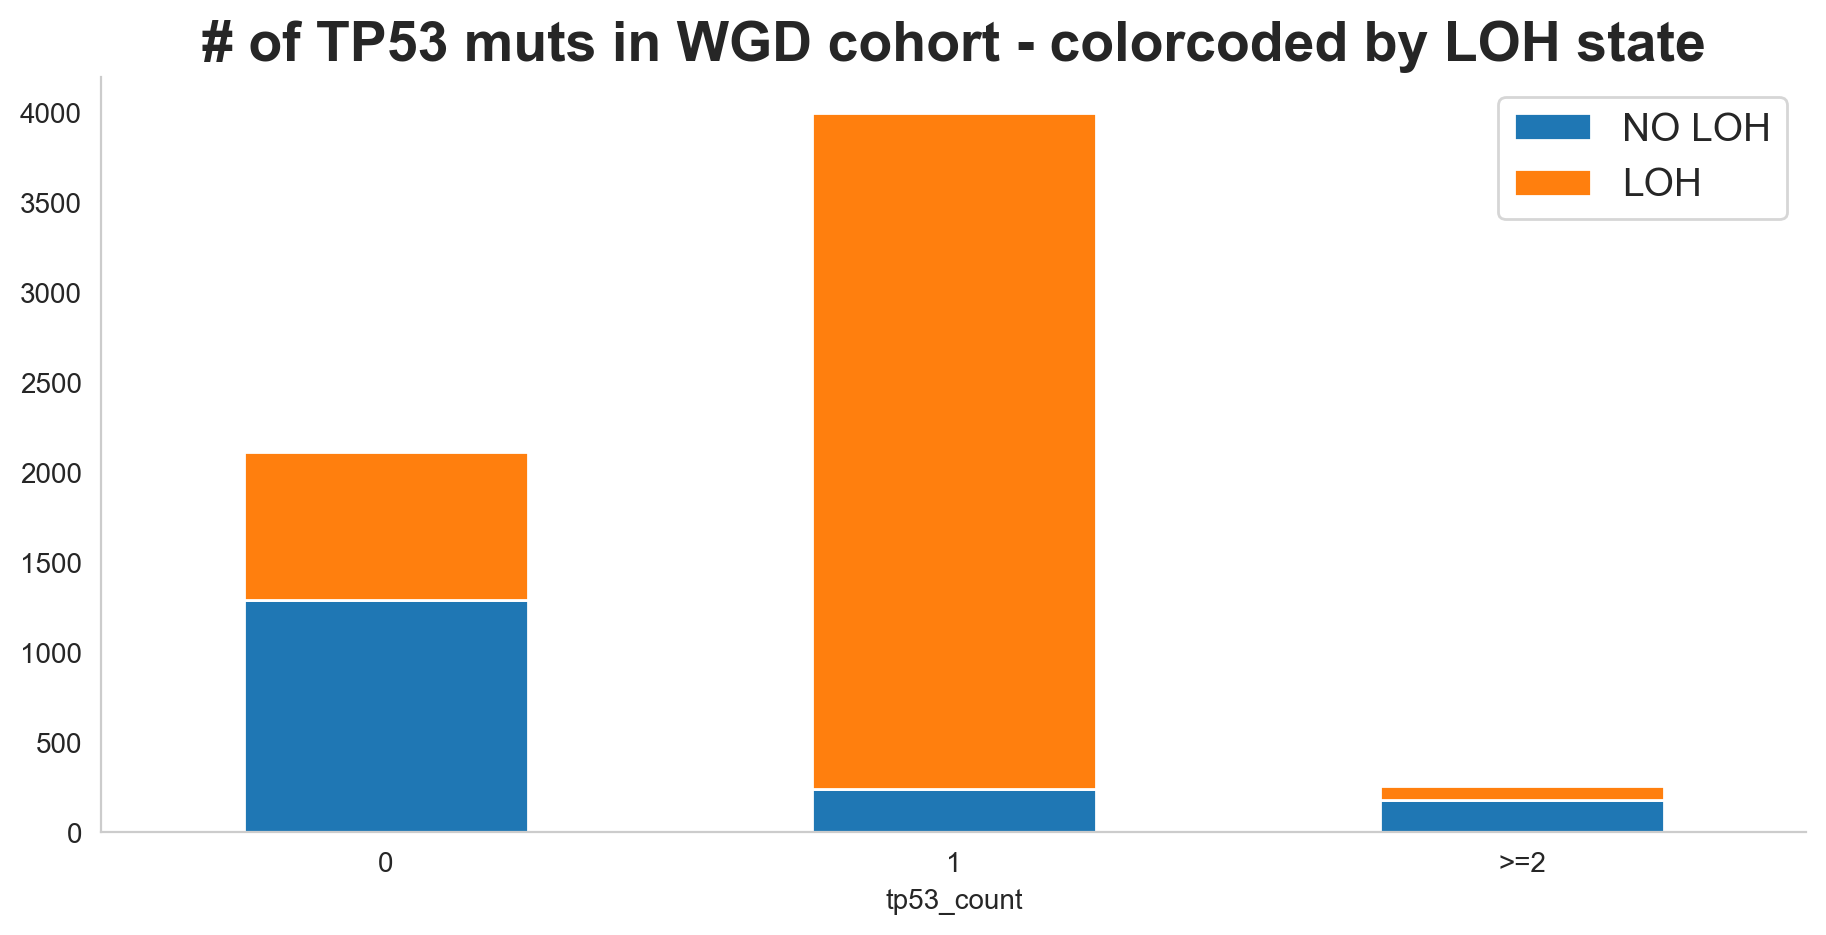

In [37]:
# First we need to groupby our cohort_wgd file to have the size of the different groups
loh_tp53count = pd.DataFrame(cohort_wgd[['tp53_count', 'LOH']].groupby(['tp53_count', 'LOH']).size()).unstack()
loh_tp53count = loh_tp53count.fillna(0)
loh_tp53count.columns=['NO LOH', 'LOH']
loh_tp53count.loc['>=2'] = [loh_tp53count['NO LOH'][2:].sum(),loh_tp53count['LOH'][2:].sum()]
loh_tp53count = loh_tp53count.drop([2,3,4,5],axis=0)
display(loh_tp53count)

sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = loh_tp53count.plot(kind = 'bar', stacked=True, ax=ax)
ax.set_xticklabels(['0', '1','>=2'], rotation=0)
ax.legend(['NO LOH', 'LOH'], fontsize=14)
ax.set_title('# of TP53 muts in WGD cohort - colorcoded by LOH state',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

So we see an enrichment of LOH in samples with 1 tp53 mutation. The questions are:
* What are the TP53 states involved in this LOH state? LOSS ? CNLOH ? 
    * For the different tp53 mutation count categories (0,1,>=2)

## WGD - TP53

In [38]:
cohort_wgd.shape[0]

6367

In [39]:
# We define gene_level_tp53 which represents gene level filtered on tp53 locus
gene_level_tp53 = gene_level[gene_level['gene'] == 'TP53']
wgd_tp53_samples = list(set(cohort_wgd[cohort_wgd['tp53_count'] >= 1].sample_id))
print('WGD - TP53: ' + str(len(wgd_tp53_samples)) + ' - ' + str(round(100*len(wgd_tp53_samples)/cohort_wgd.shape[0],2)) + ' %')


WGD - TP53: 4252 - 66.78 %


In [510]:
cohort_wgd

,sample_id,sample_path,fit_to_use,patient,tumor_sample,tumor_bamname,normal_sample,normal_bamname,tag,run_prefix,run_output_dir,run_log_dir,counts_file,has_counts_file,has_hisens_run,has_purity_run,has_qc,has_maf_anno,run_status,tumor_sample_id,path,fit_name,purity_run_version,purity_run_prefix,purity_run_Seed,purity_run_cval,purity_run_nhet,purity_run_snp_nbhd,purity_run_ndepth,purity_run_Purity,purity_run_Ploidy,purity_run_dipLogR,purity_run_alBalLogR,hisens_run_version,hisens_run_prefix,hisens_run_Seed,hisens_run_cval,hisens_run_nhet,hisens_run_snp_nbhd,hisens_run_ndepth,hisens_run_hisens,hisens_run_Ploidy,hisens_run_dipLogR,manual_note,is_best_fit,purity,ploidy,dipLogR,dipLogR_flag,n_alternative_dipLogR,wgd,n_dip_bal_segs,frac_dip_bal_segs,n_dip_imbal_segs,frac_dip_imbal_segs,n_amps,n_homdels,frac_homdels,n_homdels_clonal,frac_homdels_clonal,n_cn_states,n_segs,n_cnlr_clusters,n_lcn_na,n_loh,frac_loh,n_segs_subclonal,frac_segs_subclonal,n_segs_below_dipLogR,frac_below_dipLogR,n_segs_balanced_odd_tcn,frac_balanced_odd_tcn,n_segs_imbalanced_diploid_cn,frac_imbalanced_diploid_cn,n_segs_lcn_greater_mcn,frac_lcn_greater_mcn,n_snps,n_het_snps,frac_het_snps,n_snps_with_300x_in_tumor,n_het_snps_with_300x_in_tumor,n_het_snps_hom_in_tumor_1pct,n_het_snps_hom_in_tumor_5pct,frac_het_snps_hom_in_tumor_1pct,frac_het_snps_hom_in_tumor_5pct,mean_cnlr_residual,sd_cnlr_residual,n_segs_discordant_tcn,frac_discordant_tcn,n_segs_discordant_lcn,frac_discordant_lcn,n_segs_discordant_both,frac_discordant_both,n_segs_icn_cnlor_discordant,frac_icn_cnlor_discordant,mafr_median_all,mafr_median_clonal,mafr_n_gt_1,facets_suite_version,facets_qc_version,homdel_filter_pass,diploid_bal_seg_filter_pass,diploid_imbal_seg_filter_pass,waterfall_filter_pass,hyper_seg_filter_pass,high_ploidy_filter_pass,valid_purity_filter_pass,diploid_seg_filter_pass,em_cncf_icn_discord_filter_pass,dipLogR_too_low_filter_pass,subclonal_genome_filter_pass,icn_allelic_state_concordance_filter_pass,contamination_filter_pass,facets_qc,arm_level_file,gene_level_file,ccf_file,arm_level_file_exists,gene_level_file_exists,ccf_file_exists
2,P-0025956-T01-IM6_P-0025956-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00259/P-0025956-T01-IM6_P-0025956-N01-IM6/,NaN,P-0025956,P-0025956-T01-IM6,FL762959-T,P-0025956-N01-IM6,ZR679900-N,P-0025956-T01-IM6_P-0025956-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00259/P-0025956-T01-IM6_P-0025956-N01-IM6/,/juno/work/ccs/shared/resources/impact/facets/all/P-00259/P-0025956-T01-IM6_P-0025956-N01-IM6/default/,/juno/work/ccs/shared/resources/impact/facets/all/P-00259/P-0025956-T01-IM6_P-0025956-N01-IM6/default/logs/,/juno/work/ccs/shared/resources/impact/facets/all/P-00259/P-0025956-T01-IM6_P-0025956-N01-IM6/countsMerged____P-0025956-T01-IM6_P-0025956-N01-IM6.dat.gz,True,True,True,False,False,complete,P-0025956-T01-IM6_P-0025956-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00259/P-0025956-T01-IM6_P-0025956-N01-IM6/,default,0.5.14,/juno/work/ccs/shared/resources/impact/facets/all/P-00259/P-0025956-T01-IM6_P-0025956-N01-IM6//default/P-0025956-T01-IM6_P-0025956-N01-IM6_purity,100,100,15,250,35,0.19,3.5,-0.19,"-0.19, 0.02",0.5.14,/juno/work/ccs/shared/resources/impact/facets/all/P-00259/P-0025956-T01-IM6_P-0025956-N01-IM6//default/P-0025956-T01-IM6_P-0025956-N01-IM6_hisens,100,50,15,250,35,NaN,3.0,-0.19,NaN,False,0.185874,3.496971,-0.187925,False,0,True,2,0.096,4,0.1800,0,0,0.00000,0,0.00000,6,26,6,0,5,0.190,3,0.12,0,0.0000,4,0.1400,0,0.0000,15,0.600,17971,2159,0.12,6748,774,0,0,0.0000,0.00000,-0.052,0.30,2,0.015,0.0,0.0000,3,0.120,8,0.300,0.021,0.025,0,2.0.5,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,/juno/work/ccs/shared/resources/impact/facets/all/P-00259/P-0025956-T01-IM6_P-0025956-N01-IM6//default/P-0025956-T01-IM6_P-0025956-N01-IM6.arm_level.txt,/juno/work/ccs/shared/resources/impact/facets/all/P-00259/P-0025956-T01-IM6_P-0025956-N01-IM6//default/P-0025956-T01-IM6_P-0025956-N01-IM6.

### WGD - TP53 - LOH

In [44]:
wgd_tp53_loh_samples = list(set(cohort_wgd[cohort_wgd['LOH'] == True][cohort_wgd['tp53_count'] >= 1].sample_id))
gene_level_tp53_wgd_loh = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_tp53_loh_samples)]

In [45]:
print('WGD - TP53 - LOH: ' + str(len(wgd_tp53_loh_samples)) + ' - ' + str(round(100*len(wgd_tp53_loh_samples)/len(wgd_tp53_samples),2)) + ' %')
      

WGD - TP53 - LOH: 3835 - 90.19 %


In [46]:
h = get_groupby(gene_level_tp53_wgd_loh, 'cn_state', 'count')
LOSS = h['count']['LOSS BEFORE']
CNLOH = h.sum().values[0] - h['count']['LOSS BEFORE']
print('Number of LOSS: ' + str(LOSS) + ' - ' + str(round(100*LOSS/h.sum().values[0],2)) + ' %')
print('Number of CNLOH: ' + str(CNLOH) + ' - ' + str(round(100*CNLOH/h.sum().values[0],2)) + ' %')
h

Number of LOSS: 2830 - 73.79 %
Number of CNLOH: 1005 - 26.21 %


,count
cn_state,
CNLOH BEFORE,162
CNLOH BEFORE & GAIN,29
CNLOH BEFORE & LOSS,814
LOSS BEFORE,2830


In [47]:
# Counting the multi tp53 mutations samples in CNLOH and LOSS
samples_LOSS = list(gene_level_tp53_wgd_loh[gene_level_tp53_wgd_loh.cn_state.isin(['LOSS BEFORE'])]['sample'].str[:17])
samples_LOH = list(gene_level_tp53_wgd_loh[~gene_level_tp53_wgd_loh.cn_state.isin(['LOSS BEFORE'])]['sample'].str[:17])

print('Number of >=2muts samples in LOH: ' + str(cohort_wgd[cohort_wgd['tumor_sample'].isin(samples_LOH)][cohort_wgd['tp53_count'] >= 2].shape[0]))
print('Number of >=2muts samples in LOSS: ' + str(cohort_wgd[cohort_wgd['tumor_sample'].isin(samples_LOSS)][cohort_wgd['tp53_count'] >= 2].shape[0]))

Number of >=2muts samples in LOH: 24
Number of >=2muts samples in LOSS: 53


### WGD - TP53 - No LOH

In [48]:
wgd_tp53_noloh_samples = list(set(cohort_wgd[cohort_wgd['LOH'] == False][cohort_wgd['tp53_count'] >= 1].sample_id))
gene_level_tp53_wgd_noloh = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_tp53_noloh_samples)]

In [49]:
print('WGD - TP53 - No LOH: ' + str(len(wgd_tp53_noloh_samples)) + ' - ' + str(round(100*len(wgd_tp53_noloh_samples)/len(wgd_tp53_samples),2)) + ' %')
      

WGD - TP53 - No LOH: 417 - 9.81 %


In [50]:
# Samples with One mutation
wgd_1tp53_noloh_samples = list(set(cohort_wgd[cohort_wgd['LOH'] == False][cohort_wgd['tp53_count'] == 1].sample_id))
print( 'Number of WGD - 1tp53 - No LOH: ' + str(len(wgd_1tp53_noloh_samples)) + ' - '+ str(round(100*len(wgd_1tp53_noloh_samples)/len(wgd_tp53_noloh_samples), 2)) + ' %')

Number of WGD - 1tp53 - No LOH: 238 - 57.07 %


In [51]:
# Samples with >=2 mutations
wgd_2tp53_noloh_samples = list(set(cohort_wgd[cohort_wgd['LOH'] == False][cohort_wgd['tp53_count'] >= 2].sample_id))
print( 'Number of WGD - >=2 tp53 - No LOH: ' + str(len(wgd_2tp53_noloh_samples)) + ' - '+ str(round(100*len(wgd_2tp53_noloh_samples)/len(wgd_tp53_noloh_samples), 2)) + ' %')


Number of WGD - >=2 tp53 - No LOH: 179 - 42.93 %


## WGD - No TP53

In [52]:
wgd_notp53_samples = list(set(cohort_wgd[cohort_wgd['tp53_count'] == 0].sample_id))
gene_level_tp53_wgd_notp53 = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_notp53_samples)]

In [53]:
print('WGD - No TP53: ' + str(len(wgd_notp53_samples)) + ' - ' + str(round(100*len(wgd_notp53_samples)/cohort_wgd.shape[0],2)) + ' %')

WGD - No TP53: 2115 - 33.22 %


### WGD - No TP53 - No LOH

In [54]:
# Now we count the number of samples with WGD - No TP53 mut - No LOH
wgd_notp53_noloh_samples = list(set(cohort_wgd[cohort_wgd['tp53_count'] == 0][cohort_wgd['LOH'] == False].sample_id))
gene_level_tp53_wgd_notp53_noloh = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_notp53_noloh_samples)]
print('WGD - No TP53 - No LOH : ' + str(len(wgd_notp53_noloh_samples)) + ' - ' + str(round(100*len(wgd_notp53_noloh_samples)/len(wgd_notp53_samples), 2)) + ' %')

WGD - No TP53 - No LOH : 1291 - 61.04 %


In [55]:
# What are the different CN_states
get_groupby(gene_level_tp53_wgd_notp53_noloh, 'cn_state', 'count').sort_values(by='count', ascending=False)

,count
cn_state,
LOSS AFTER,656
DOUBLE LOSS AFTER,331
TETRAPLOID,277
CNLOH AFTER,27


### WGD - No TP53 - LOH

In [56]:
# Now we count the number of samples with WGD - No TP53 mut - LOH
wgd_notp53_loh_samples = list(set(cohort_wgd[cohort_wgd['tp53_count'] == 0][cohort_wgd['LOH'] == True].sample_id))
gene_level_tp53_wgd_notp53_loh = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_notp53_loh_samples)]
print('WGD - No TP53 - LOH : ' + str(len(wgd_notp53_loh_samples)) + ' - ' + str(round(100*len(wgd_notp53_loh_samples)/len(wgd_notp53_samples), 2)) + ' %')

WGD - No TP53 - LOH : 824 - 38.96 %


Let's dig in the different Copy Number States involved in the *WGD - No TP53 - LOH* subcohort

In [57]:
h = get_groupby(gene_level_tp53_wgd_notp53_loh, 'cn_state', 'count')
LOSS = h['count']['LOSS BEFORE'] 
CNLOH = h.sum().values[0] - h['count']['LOSS BEFORE'] 
print('Number of LOSS: ' + str(LOSS) + ' - ' + str(round(100*LOSS/h.sum().values[0],2)) + ' %')
print('Number of CNLOH: ' + str(CNLOH) + ' - ' + str(round(100*CNLOH/h.sum().values[0],2)) + ' %')
h

Number of LOSS: 670 - 81.31 %
Number of CNLOH: 154 - 18.69 %


,count
cn_state,
CNLOH BEFORE,18
CNLOH BEFORE & GAIN,2
CNLOH BEFORE & LOSS,134
LOSS BEFORE,670


# Timing TP53 mutations

In [58]:
# We begin by defining the WGD - TP53 Cohort

gene_level_tp53 = gene_level[gene_level['gene'] == 'TP53']

cohort_wgd_tp53 = cohort_wgd[cohort_wgd['tp53_count'] >= 1]
wgd_tp53_samples = list(set(cohort_wgd_tp53.sample_id))
wgd_tp53_tumors = list(set(cohort_wgd_tp53.tumor_sample))

gene_level_tp53_wgd = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_tp53_samples)]
maf_cohort_wgd_tp53 = maf_cohort[maf_cohort['Tumor_Sample_Barcode'].isin(wgd_tp53_tumors)][maf_cohort['Hugo_Symbol'] == 'TP53']


In [59]:
print('Total number of mutations in WGD - TP53: ' + str(maf_cohort_wgd_tp53.shape[0]))

Total number of mutations in WGD - TP53: 4529


We will add a  column to **maf_cohort_wgd_tp53** called *tp53_res*.

In [60]:
%%time

def get_tp53_res(x):
    tumor = x.Tumor_Sample_Barcode
    pur = x.purity
    vaf = x.t_var_freq
    tcn = gene_level_tp53_wgd[gene_level_tp53_wgd['sample'].str[:17] == tumor]['tcn'].values[0]
    
    tp53_exp_nb = (vaf/pur) * (tcn * pur + 2 * (1 - pur))
    tp53_res = tcn - tp53_exp_nb
    
    return tp53_res

maf_cohort_wgd_tp53['tp53_res'] = maf_cohort_wgd_tp53.apply(get_tp53_res, axis=1)

CPU times: user 8.68 s, sys: 52.5 ms, total: 8.73 s
Wall time: 8.72 s


Let's have a look to the distribution of tp53_res:

In [61]:
maf_cohort_wgd_tp53.tp53_res.isna().sum()#describe()

0

We see that we have 25% of our tp53 mutations with a negative tp53_res. What does that mean?

Basically, having a look to the computation to reach tp53_res, there are two main actors: the *vaf* and the *purity*. If the purity is low, then we will have a low - or negative - tp53_res. But we cut the cohort with purity > 0.2. On the other hand the vaf can be very high. It is indeed. the case in the negative. tp53_res mutations. 

Let's see the difference of vaf for tp53_res > 0 and tp53_res <0 in the next cell:

In [62]:
# In this cell we get the tp53_res distribution for the cn_state considered

h0 = pd.DataFrame(maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['tp53_res']<0].t_var_freq.describe())#.tp53_res.describe()
h1 = pd.DataFrame(maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['tp53_res']>=0].t_var_freq.describe())

print( '    tp53<0     |     tp53>=0')
display_side_by_side(h0, h1)

    tp53<0     |     tp53>=0


,t_var_freq
count,1464.000000
mean,0.577617
std,0.196463
min,0.216646
25%,0.413260
50%,0.556364
75%,0.733918
max,0.992523
,t_var_freq
count,3065.000000


In [63]:
get_groupby(gene_level_tp53_wgd, 'cn_state', 'count').sort_values(by='count', ascending=False)

,count
cn_state,
LOSS BEFORE,2830
CNLOH BEFORE & LOSS,814
LOSS AFTER,217
CNLOH BEFORE,162
DOUBLE LOSS AFTER,102
TETRAPLOID,66
CNLOH AFTER,32
CNLOH BEFORE & GAIN,29


Now let's create a column with the timing of the tp53 mutation.
For that purpose, we use the cn_state of each sample to see what are the possibilities in terms of tp53_res.

Let's take an example: **LOSS BEFORE** (aka the most represented cn_state in our subcohort)

To sum up the different steps of this cn_state: 
1. we have a DIPLOID state (1/1)
2. We have a LOSS (1/0)
3. We have a WGD 'duplicating' this allele (2/0)

We have 2 possibilities for the mutation:
1. If it arose before WGD, the theoretical tp53_res is 0 because we have one allele mutated (after the LOSS) that is duplicated.
2. If it arose after WGD, the theoretical tp53_res is 1 because we have one allele mutated AND one WT allele.


In this case it is pretty easy: if tp53_res == 0   ==>  BEFORE

But do not forget that tp53_res is a statistical measurement, so we have to set up a threshold to capture as many confident samples as we can.
We can take thr = 0.5 for example.

The mecanism is the same with all cn_states. But some are very difficult.

In [64]:
def get_tp53_timing_wgd(x):
    tumor = x.Tumor_Sample_Barcode
    tp53_res = x.tp53_res
    cn_state = gene_level_tp53_wgd[gene_level_tp53_wgd['sample'].str[:17] == tumor]['cn_state'].values[0]
    
    # Now we enumerate all cn_state and put a threshold
    if cn_state == 'LOSS BEFORE':
        thr = 0.5
    elif cn_state ==  'CNLOH BEFORE & LOSS':
        thr = 1
    elif cn_state == 'CNLOH BEFORE':
        thr = 2.5
    # The following is tricky because tp53_res=2 could be in both cases
    elif cn_state == 'LOSS AFTER':
        thr = 1.25
    elif cn_state == 'DOUBLE LOSS AFTER':
        thr = 0.25
    elif cn_state == 'TETRAPLOID':
        thr = 2.5
    elif cn_state == 'CNLOH AFTER':
        thr = 1.5
    elif cn_state == 'CNLOH BEFORE & GAIN':
        thr = 2
    # For all other cases we put thr = -1 for INDETERMINATE
    else:
        thr = -1
    
    if thr != -1:
        if tp53_res <= thr:
            return 'BEFORE'
        elif tp53_res > thr:
            return 'AFTER'
        else: return 'INDETERMINATE'
    elif thr == -1:
        return 'INDETERMINATE'
    
maf_cohort_wgd_tp53['tp53_timing_wgd'] = maf_cohort_wgd_tp53.apply(get_tp53_timing_wgd, axis=1)

In [65]:
h = pd.DataFrame(get_groupby(maf_cohort_wgd_tp53,'tp53_timing_wgd', 'count').sort_values(by='count', ascending=False))
display(h)

print('Number of TP53 mutations that had arisen BEFORE WGD: ' + str(h.iloc[0,0]) + ' - ' + str(round(100*h.iloc[0,0]/h.sum().values[0],2)) + ' %')

print('Number of TP53 mutations that had arisen AFTER WGD: ' + str(h.iloc[1,0]) + ' - ' + str(round(100*h.iloc[1,0]/h.sum().values[0],2)) + ' %')




,count
tp53_timing_wgd,
BEFORE,3895
AFTER,634


Number of TP53 mutations that had arisen BEFORE WGD: 3895 - 86.0 %
Number of TP53 mutations that had arisen AFTER WGD: 634 - 14.0 %


We have a proportion of 73.2%, which slightly less than Bielsky's paper published in Nature on WGD in prognosis. They have a number of 97.3% on 1 174 mutations. 

BUT they excluded from the cohort all ambiguous cases, and they used a simplier way to assess the timing on mutations. 

In [66]:
# In this cell we check the tp53_res distribution for a given tp53_cn_state
cn_state = 'TETRAPLOID'
samples = list(set(gene_level_tp53_wgd[gene_level_tp53_wgd['cn_state'] == cn_state]['sample'].str[:17]))
pd.DataFrame(maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['Tumor_Sample_Barcode'].isin(samples)].tp53_res.describe())

,tp53_res
count,109.000000
mean,2.128207
std,0.699913
min,-0.042831
25%,1.928023
50%,2.088627
75%,2.432211
max,3.795463


# Allelic State before WGD
Thanks to the tp53 mutation timing, we can compute pre-WGD allelic state of our samples.

For that, we need to separate 1mut samples and multi-mut samples: indeed the allelic state highly depends on the number of mutaions

In [67]:
'''
            NUMBER OF TP53 residual ASSOCIATED WITH ALLELIC STATE BEFORE WGD
            
            
                                     BI-ALLELIC | MONO - ALLELIC | 2WT

                LOSS BEFORE :            0      |        1       | -
                CNLOH BEFORE & LOSS:     0      |       1,2      | 2
                CNLOH BEFORE:            0      |        2       | 3
                LOSS AFTER:              -      |       1,2      | 2
                DOUBLE LOSS AFTER:       -      |       0,1      | 1
                TETRAPLOID:              -      |        2       | 3
                CNLOH AFTER:             -      |       1,3      | 3
                CNLOH BEFORE & GAIN:     0      |        2,3     | 3,4
                

                        THRESHOLDS BETWEEN ALLELIC STATES BEFORE WGD
                    
                                     BI-ALLELIC | MONO - ALLELIC | 2WT

                LOSS BEFORE :            <0.4   |        >0.6    | -
                CNLOH BEFORE & LOSS:     <0.4   |      0.6< <1.5 | uncertain
                CNLOH BEFORE:            <1.5   |   1.5< <2.5    | >2.5
                LOSS AFTER:              -      |      <1.5      | uncertain 
                DOUBLE LOSS AFTER:       -      |       <0.5     | uncertain
                TETRAPLOID:              -      |       <2.5     | >2.5
                CNLOH AFTER:             -      |       <1.5     | uncertain
                CNLOH BEFORE & GAIN:     <1.4   |   1.6< <2.5    | uncertain
                
    

 '''

'\n            NUMBER OF TP53 residual ASSOCIATED WITH ALLELIC STATE BEFORE WGD\n            \n            \n                                     BI-ALLELIC | MONO - ALLELIC | 2WT\n\n                LOSS BEFORE :            0      |        1       | -\n                CNLOH BEFORE & LOSS:     0      |       1,2      | 2\n                CNLOH BEFORE:            0      |        2       | 3\n                LOSS AFTER:              -      |       1,2      | 2\n                DOUBLE LOSS AFTER:       -      |       0,1      | 1\n                TETRAPLOID:              -      |        2       | 3\n                CNLOH AFTER:             -      |       1,3      | 3\n                CNLOH BEFORE & GAIN:     0      |        2,3     | 3,4\n                \n\n                        THRESHOLDS BETWEEN ALLELIC STATES BEFORE WGD\n                    \n                                     BI-ALLELIC | MONO - ALLELIC | 2WT\n\n                LOSS BEFORE :            <0.4   |        >0.6    | -\

## 1mut Samples

In [68]:
def get_bi_nobi(x):
    tumor = x.tumor_sample
    cn_state = gene_level_tp53_wgd[gene_level_tp53_wgd['sample'].str[:17] == tumor]['cn_state'].values[0]
    tp53_count = x.tp53_count
    maf_muts = maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['Tumor_Sample_Barcode'] == tumor]
    nb_tp53muts = maf_muts.shape[0]
    
    # Samples with only one tp53 mutation
    if nb_tp53muts == 1:
        tp53_res = maf_muts.tp53_res.values[0]
        
        if cn_state == 'LOSS BEFORE' or cn_state == 'CNLOH BEFORE & LOSS':
            thr = 0.5
            if tp53_res < thr - 0.1:
                return 'bi'
            elif (tp53_res < thr + 0.1) and (tp53_res > thr - 0.1):
                return 'uncertain'
            elif tp53_res > thr + 0.1:
                return 'no_bi'

        elif cn_state == 'CNLOH BEFORE':
            thr = 1.5
            if tp53_res < thr:
                return 'bi'
            elif tp53_res >= thr:
                return 'no_bi'

        elif cn_state in ['LOSS AFTER','DOUBLE LOSS AFTER','TETRAPLOID','CNLOH AFTER']: 
            return 'no_bi'

        elif cn_state == 'CNLOH BEFORE & GAIN':
            thr = 1.5
            if tp53_res < thr - 0.1:
                return 'bi'
            elif (tp53_res < thr + 0.1) and (tp53_res > thr - 0.1):
                return 'uncertain'
            elif tp53_res > thr + 0.1:
                return 'no_bi'
            
            
            
    # Samples with 2 tp53 mutations
    elif nb_tp53muts == 2:
        tp53_res_1 = maf_muts.tp53_res.values[0]
        tp53_res_2 = maf_muts.tp53_res.values[1]
        timing_1 = maf_muts.tp53_timing_wgd.values[0]
        timing_2 = maf_muts.tp53_timing_wgd.values[1]
        
        if cn_state == 'LOSS BEFORE':
            thr = 0.5
            if (tp53_res_1 < thr - 0.1) or (tp53_res_2 < thr - 0.1):
                return 'bi'
            elif (tp53_res_1 > thr + 0.1) and (tp53_res_2 > thr + 0.1):
                return 'no_bi'
            else: return 'uncertain'
            
        if cn_state == 'CNLOH BEFORE & LOSS':
            thr_1 = 0.5
            thr_2 = 1.5
            if (tp53_res_1 < thr_1 - 0.1) or (tp53_res_2 < thr_1 - 0.1):
                return 'bi'
            elif (tp53_res_1 < thr_2 and tp53_res_2 < thr_2):
                return 'bi'
            else: return 'no_bi'
            
        elif cn_state == 'CNLOH BEFORE':
            thr_1 = 1.5
            thr_2 = 2.5
            if (tp53_res_1 < thr_1) or (tp53_res_2 < thr_1):
                return 'bi'
            elif (tp53_res_1 < thr_2 and tp53_res_2 < thr_2):
                return 'bi'
            else: return 'no_bi'

        elif cn_state =='LOSS AFTER': 
            thr = 1.5
            if (tp53_res_1 < thr) and (tp53_res_2 < thr):
                return 'bi'
            else: return 'no_bi'
            
        elif cn_state =='DOUBLE LOSS AFTER': 
            thr = 0.5
            if (tp53_res_1 < thr) and (tp53_res_2 < thr):
                return 'bi'
            else: return 'no_bi'
        
        elif cn_state =='TETRAPLOID': 
            thr = 2.5
            if (tp53_res_1 < thr) and (tp53_res_2 < thr):
                return 'bi'
            else: return 'no_bi'
            
        elif cn_state =='CNLOH AFTER': 
            thr = 1.5
            if (tp53_res_1 < thr) and (tp53_res_2 < thr):
                return 'bi'
            else: return 'no_bi'
        
        elif cn_state == 'CNLOH BEFORE & GAIN':
            thr_1 = 1.5
            thr_2 = 2.5
            if tp53_res_1 < thr_1 - 0.1 or tp53_res_2 < thr_1 - 0.1:
                return 'bi'
            elif (tp53_res_1 > thr_2) and (tp53_res_2 > thr_2):
                return 'no_bi'
            else: return 'uncertain'
            
            
    # Samples with 3 tp53 mutations
    elif nb_tp53muts == 3:
        tp53_res_1 = maf_muts.tp53_res.values[0]
        tp53_res_2 = maf_muts.tp53_res.values[1]
        tp53_res_3 = maf_muts.tp53_res.values[2]
        tp53_res = [tp53_res_1,tp53_res_2,tp53_res_3]
        tp53_res.sort()
        
        timing_1 = maf_muts.tp53_timing_wgd.values[0]
        timing_2 = maf_muts.tp53_timing_wgd.values[1]
        timing_3 = maf_muts.tp53_timing_wgd.values[2]
        timings = [timing_1, timing_2, timing_3]
        BEF = [1 for x in timings if x=='BEFORE']
        
        # Number of mutations happening before wgd
        nb_bef = len(BEF)
        
        if cn_state == 'LOSS BEFORE':
            thr = 0.5
            if (min(tp53_res) < thr - 0.1):
                return 'bi'
            elif (max(tp53_res) > thr + 0.1) :
                return 'no_bi'
            else: return 'uncertain'
            
        if cn_state == 'CNLOH BEFORE & LOSS':
            thr_1 = 0.5
            thr_2 = 1.5
            if (min(tp53_res) < thr_1 - 0.1):
                return 'bi'
            elif (tp53_res[1] < thr_2): # we want that exactly 2 mutation arose before WGD
                return 'bi'
            else: return 'no_bi'
            
        elif cn_state == 'CNLOH BEFORE':
            thr_1 = 1.5
            thr_2 = 2.5
            if (min(tp53_res) < thr_1):
                return 'bi'
            elif (tp53_res[1] < thr_2):
                return 'bi'
            else: return 'no_bi'

        elif cn_state =='LOSS AFTER': 
            thr = 1.5
            if (tp53_res[1] < thr):
                return 'bi'
            else: return 'no_bi'
            
        elif cn_state =='DOUBLE LOSS AFTER': 
            thr = 0.5
            if (tp53_res[1] < thr):
                return 'bi'
            else: return 'no_bi'
        
        elif cn_state =='TETRAPLOID': 
            thr = 2.5
            if (tp53_res[1] < thr):
                return 'bi'
            else: return 'no_bi'
            
        elif cn_state =='CNLOH AFTER': 
            thr = 1.5
            if (tp53_res[1] < thr):
                return 'bi'
            else: return 'no_bi'
        
        elif cn_state == 'CNLOH BEFORE & GAIN':
            thr_1 = 1.5
            thr_2 = 2.5
            if min(tp53_res) < thr_1 - 0.1 :
                return 'bi'
            elif (tp53_res[1] > thr_2):
                return 'no_bi'
            else: return 'uncertain'
    
    else: return 'uncertain'

In [69]:
from tqdm import tqdm,tqdm_notebook
tqdm_notebook().pandas()
cohort_wgd_tp53['bi_state_wgd'] = cohort_wgd_tp53.progress_apply(get_bi_nobi, axis=1)

In [70]:
get_groupby(cohort_wgd_tp53, 'bi_state_wgd', 'count').sort_values(by='count', ascending=False)

,count
bi_state_wgd,
bi,3307
no_bi,673
uncertain,272


In [71]:
'''
                             THRESHOLDS BETWEEN ALLELIC STATES BEFORE WGD
                    
                                     BI-ALLELIC | MONO - ALLELIC | 2WT

                LOSS BEFORE :            <0.4   |        >0.6    | -
                CNLOH BEFORE & LOSS:     <0.4   |      0.6< <1.5 | uncertain
                CNLOH BEFORE:            <1.5   |   1.5< <2.5    | >2.5
                LOSS AFTER:              -      |      <1.5      | uncertain 
                DOUBLE LOSS AFTER:       -      |       <0.5     | uncertain
                TETRAPLOID:              -      |       <2.5     | >2.5
                CNLOH AFTER:             -      |       <1.5     | uncertain
                CNLOH BEFORE & GAIN:     <1.4   |   1.6< <2.5    | uncertain
'''


def get_mono(x):
    tumor = x.tumor_sample
    cn_state = gene_level_tp53_wgd[gene_level_tp53_wgd['sample'].str[:17] == tumor]['cn_state'].values[0]
    tp53_count = x.tp53_count
    maf_muts = maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['Tumor_Sample_Barcode'] == tumor]
    nb_tp53muts = maf_muts.shape[0]
    bi_state = x.bi_state_wgd
    
    if bi_state == 'bi':
        return 'bi'
    
    elif bi_state == 'uncertain':
        return 'uncertain_bi'
    
    
    elif bi_state == 'no_bi': # We are already in the  mono/2WT distinction 
        
        #1 mut samples
        if nb_tp53muts == 1:
            tp53_res = maf_muts.tp53_res.values[0]
            
            if cn_state == 'LOSS BEFORE':
                return 'mono'
            elif cn_state == 'CNLOH BEFORE' or cn_state == 'TETRAPLOID':
                if tp53_res < 2.5:
                    return 'mono'
                elif tp53_res > 2.5:
                    return '2WT'
                
            else: return 'uncertain_mono'

        
        # 2 mut samples   
        elif nb_tp53muts == 2:
            tp53_res_1 = maf_muts.tp53_res.values[0]
            tp53_res_2 = maf_muts.tp53_res.values[1]
            
            if cn_state == 'LOSS BEFORE':
                return 'mono'
            elif cn_state == 'CNLOH BEFORE' or cn_state == 'TETRAPLOID':
                if tp53_res_1 < 2.5 or tp53_res_2 < 2.5:
                    return 'mono'
                elif tp53_res_1 > 2.5 and tp53_res_2 > 2.5:
                    return '2WT'
                
            else: return 'uncertain_mono'
            
        # 3 mut samples
        elif nb_tp53muts == 3:
            tp53_res_1 = maf_muts.tp53_res.values[0]
            tp53_res_2 = maf_muts.tp53_res.values[1]
            tp53_res_3 = maf_muts.tp53_res.values[2]
            tp53_res = [tp53_res_1,tp53_res_2,tp53_res_3]
            tp53_res.sort()
            
            if cn_state == 'LOSS BEFORE':
                return 'mono'
            elif cn_state == 'CNLOH BEFORE' or cn_state == 'TETRAPLOID':
                if min(tp53_res) < 2.5:
                    return 'mono'
                elif tp53_res[0] > 2.5:
                    return '2WT'
                
            else: return 'uncertain_mono'
        
        else: return 'uncertain_mono'
            

In [72]:
from tqdm import tqdm,tqdm_notebook
tqdm_notebook().pandas()
cohort_wgd_tp53['allelic_state_wgd'] = cohort_wgd_tp53.progress_apply(get_mono, axis=1)

In [73]:
get_groupby(cohort_wgd_tp53, 'allelic_state_wgd', 'count').sort_values(by='count', ascending=False)

,count
allelic_state_wgd,
bi,3307
uncertain_mono,512
uncertain_bi,272
mono,148
2WT,13


In [74]:
cohort_wgd_tp53.head()

,sample_id,sample_path,fit_to_use,patient,tumor_sample,tumor_bamname,normal_sample,normal_bamname,tag,run_prefix,run_output_dir,run_log_dir,counts_file,has_counts_file,has_hisens_run,has_purity_run,has_qc,has_maf_anno,run_status,tumor_sample_id,path,fit_name,purity_run_version,purity_run_prefix,purity_run_Seed,purity_run_cval,purity_run_nhet,purity_run_snp_nbhd,purity_run_ndepth,purity_run_Purity,purity_run_Ploidy,purity_run_dipLogR,purity_run_alBalLogR,hisens_run_version,hisens_run_prefix,hisens_run_Seed,hisens_run_cval,hisens_run_nhet,hisens_run_snp_nbhd,hisens_run_ndepth,hisens_run_hisens,hisens_run_Ploidy,hisens_run_dipLogR,manual_note,is_best_fit,purity,ploidy,dipLogR,dipLogR_flag,n_alternative_dipLogR,wgd,n_dip_bal_segs,frac_dip_bal_segs,n_dip_imbal_segs,frac_dip_imbal_segs,n_amps,n_homdels,frac_homdels,n_homdels_clonal,frac_homdels_clonal,n_cn_states,n_segs,n_cnlr_clusters,n_lcn_na,n_loh,frac_loh,n_segs_subclonal,frac_segs_subclonal,n_segs_below_dipLogR,frac_below_dipLogR,n_segs_balanced_odd_tcn,frac_balanced_odd_tcn,n_segs_imbalanced_diploid_cn,frac_imbalanced_diploid_cn,n_segs_lcn_greater_mcn,frac_lcn_greater_mcn,n_snps,n_het_snps,frac_het_snps,n_snps_with_300x_in_tumor,n_het_snps_with_300x_in_tumor,n_het_snps_hom_in_tumor_1pct,n_het_snps_hom_in_tumor_5pct,frac_het_snps_hom_in_tumor_1pct,frac_het_snps_hom_in_tumor_5pct,mean_cnlr_residual,sd_cnlr_residual,n_segs_discordant_tcn,frac_discordant_tcn,n_segs_discordant_lcn,frac_discordant_lcn,n_segs_discordant_both,frac_discordant_both,n_segs_icn_cnlor_discordant,frac_icn_cnlor_discordant,mafr_median_all,mafr_median_clonal,mafr_n_gt_1,facets_suite_version,facets_qc_version,homdel_filter_pass,diploid_bal_seg_filter_pass,diploid_imbal_seg_filter_pass,waterfall_filter_pass,hyper_seg_filter_pass,high_ploidy_filter_pass,valid_purity_filter_pass,diploid_seg_filter_pass,em_cncf_icn_discord_filter_pass,dipLogR_too_low_filter_pass,subclonal_genome_filter_pass,icn_allelic_state_concordance_filter_pass,contamination_filter_pass,facets_qc,arm_level_file,gene_level_file,ccf_file,arm_level_file_exists,gene_level_file_exists,ccf_file_exists,LOH,tp53_count,bi_state_wgd,allelic_state_wgd
7,P-0036909-T01-IM6_P-0036909-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00369/P-0036909-T01-IM6_P-0036909-N01-IM6/,NaN,P-0036909,P-0036909-T01-IM6,FX156857-T,P-0036909-N01-IM6,GW614282-N,P-0036909-T01-IM6_P-0036909-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00369/P-0036909-T01-IM6_P-0036909-N01-IM6/,/juno/work/ccs/shared/resources/impact/facets/all/P-00369/P-0036909-T01-IM6_P-0036909-N01-IM6/default/,/juno/work/ccs/shared/resources/impact/facets/all/P-00369/P-0036909-T01-IM6_P-0036909-N01-IM6/default/logs/,/juno/work/ccs/shared/resources/impact/facets/all/P-00369/P-0036909-T01-IM6_P-0036909-N01-IM6/countsMerged____P-0036909-T01-IM6_P-0036909-N01-IM6.dat.gz,True,True,True,False,False,complete,P-0036909-T01-IM6_P-0036909-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00369/P-0036909-T01-IM6_P-0036909-N01-IM6/,default,0.5.14,/juno/work/ccs/shared/resources/impact/facets/all/P-00369/P-0036909-T01-IM6_P-0036909-N01-IM6//default/P-0036909-T01-IM6_P-0036909-N01-IM6_purity,100,100,15,250,35,0.38,2.9,-0.22,"-0.22, 0.08",0.5.14,/juno/work/ccs/shared/resources/impact/facets/all/P-00369/P-0036909-T01-IM6_P-0036909-N01-IM6//default/P-0036909-T01-IM6_P-0036909-N01-IM6_hisens,100,50,15,250,35,NaN,2.9,-0.22,NaN,False,0.384643,2.871793,-0.223626,False,0,True,1,0.072,2,0.036,1,0,0.00000,0,0.00000,13,46,17,7,15,0.25,18,0.46,8,0.100,0,0.0000,1,0.0053,16,0.34,22674,2719,0.12,9206,1084,0,0,0.00000,0.00000,-0.075,0.34,2,0.038,0.0,0.0000,3,0.096,4,0.039,0.089,0.160,2,2.0.5,1,True,True,False,True,True,True,True,True,True,True,True,True,True,True,/juno/work/ccs/shared/resources/impact/facets/all/P-00369/P-0036909-T01-IM6_P-0036909-N01-IM6//default/P-0036909-T01-IM6_P-0036909-N01-IM6.arm_level.txt,/juno/work/ccs/shared/resources/impact/facets/all/P-00369/P-0036909-T01-IM6_P-0036909-N01-

# Appendix

## Distribution of tp53_res in different cn_states

Here we want to show the distribution (overall - for each cn_state) of tp53_res for WGD - TP53 subcohort.

In [75]:
maf_cohort_wgd_tp53
cohort_wgd_tp53
gene_level_tp53_wgd

,sample,gene,chrom,gene_start,gene_end,tsg,seg,median_cnlr_seg,segclust,seg_start,seg_end,cf.em,tcn.em,lcn.em,cf,tcn,lcn,seg_length,mcn,genes_on_seg,gene_snps,gene_het_snps,spans_segs,cn_state,filter
12,P-0036909-T01-IM6_P-0036909-N01-IM6,TP53,17,7565097,7590868,True,48,-0.232961,9,114669,18216598,0.306121,2,0.0,0.306121,2,0.0,18101929,2.0,311,26,1,False,LOSS BEFORE,PASS
18,P-0023546-T01-IM6_P-0023546-N01-IM6,TP53,17,7565097,7590868,True,80,-0.087031,28,114530,25365000,0.835504,3,0.0,0.835504,3,0.0,25250470,3.0,351,22,5,False,CNLOH BEFORE & LOSS,PASS
20,P-0023546-T02-IM6_P-0023546-N01-IM6,TP53,17,7565097,7590868,True,73,-0.406350,14,114530,25352300,0.312907,2,0.0,0.312907,2,0.0,25237770,2.0,351,22,5,False,LOSS BEFORE,PASS
38,P-0018837-T01-IM6_P-0018837-N01-IM6,TP53,17,7565097,7590868,True,69,-0.197946,10,114639,25346614,0.257400,3,0.0,0.257400,3,0.0,25231975,3.0,351,19,2,False,CNLOH BEFORE & LOSS,PASS
44,P-0019444-T01-IM6_P-0019444-N01-IM6,TP53,17,7565097,7590868,True,41,-0.076142,10,3958459,56811700,0.292235,3,1.0,0.292235,3,1.0,52853241,2.0,826,22,5,False,LOSS AFTER,PASS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71619,P-0050468-T01-IM6_P-0050468-N01-IM6,TP53,17,7565097,7590868,True,38,-0.220417,4,114669,41412250,0.270982,2,0.0,0.270982,2,0.0,41297581,2.0,696,24,0,False,LOSS BEFORE,PASS
71637,P-0050674-T01-IM6_P-0050674-N01-IM6,TP53,17,7565097,7590868,True,32,-0.354240,5,114639,21535775,0.262533,2,0.0,0.262533,2,0.0,21421136,2.0,349,26,0,False,LOSS BEFORE,PASS
71643,P-0050669-T01-IM6_P-0050669-N01-IM6,TP53,17,7565097,7590868,True,86,-0.440564,14,114669,78938250,0.637791,2,0.0,0.637791,2,0.0,78823581,2.0,1138,27,0,False,LOSS BEFORE,PASS
71649,P-0009110-T02-IM6_P-0009110-N01-IM6,TP53,17,7565097,7590868,True,59,0.041211,18,3958105,11396600,0.239690,4,0.0,0.239690,4,0.0,7438495,4.0,183,26,4,False,CNLOH BEFORE,PASS


In [76]:
def plot_density(xlabel='', ylabel='', title='',clip = (0,3), group = None,  figsize=(5,5)):
    sns.set_style("whitegrid", {'grid.color': '1.'})
    fig, ax = plt.subplots(figsize=figsize)
    if group:
        samples = list(set(gene_level_tp53_wgd[gene_level_tp53_wgd['cn_state'] == group]['sample'].str[:17]))
    else:
        samples = list(set(gene_level_tp53_wgd['sample'].str[:17]))
    
    data = maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['Tumor_Sample_Barcode'].isin(samples)]['tp53_res']
    ax = sns.distplot(data,kde_kws={'clip': clip, "shade": True}, hist=False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title('TP53 residual density (' + str(len(samples)) + ')' + title , weight = 'bold')
    
    mean=round(data.mean(),2) ; median=round(data.median(),2)
    string = 'Mean: '+ str(mean) +'\nMedian: ' + str(median)
    ax.axvline(mean, color='g', linestyle='-', label='Mean: '+ str(mean))
    ax.axvline(median, color='b', linestyle='-', label='Median: ' + str(median))
    ax.legend()
    
    plt.show()

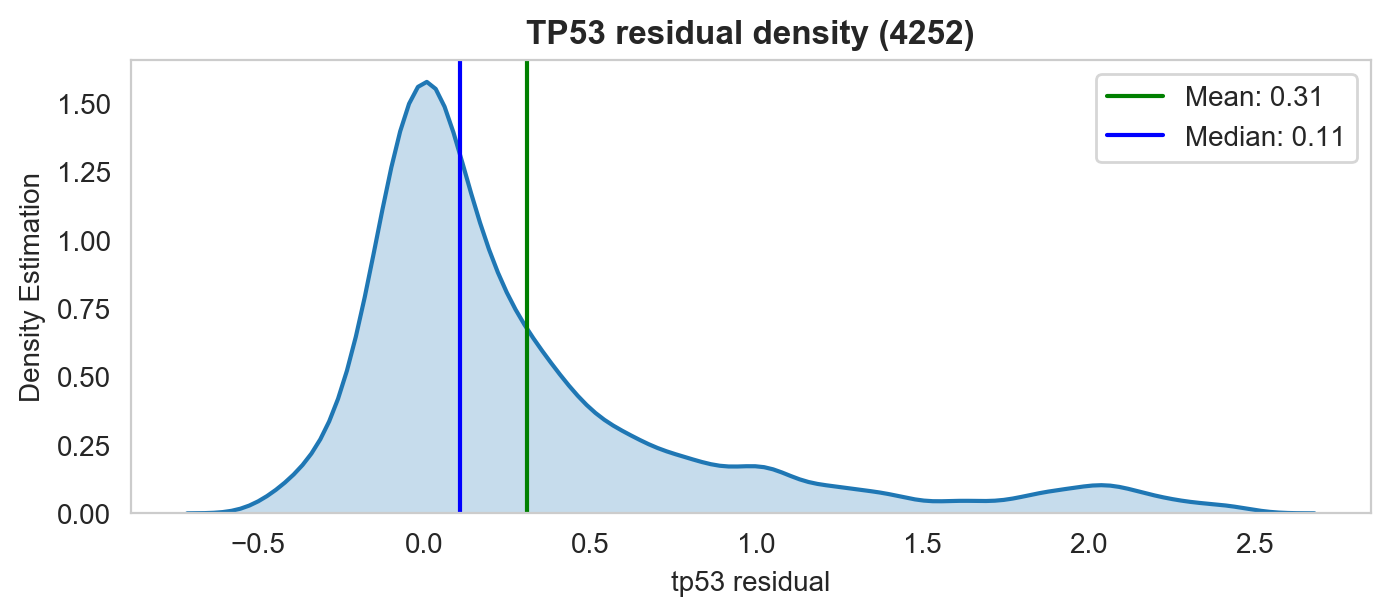

In [77]:
plot_density(xlabel='tp53 residual', 
             ylabel='Density Estimation', 
             title='', 
             clip=(-0.5,2.5),
             group = None,  
             figsize=(8,3))

Now, let's have a look at tp53 residual distributions for different cn_state, it will allow us to fine tune our thresholds.

In [78]:
get_groupby(gene_level_tp53_wgd, 'cn_state', 'count').sort_values(by='count', ascending=False)

,count
cn_state,
LOSS BEFORE,2830
CNLOH BEFORE & LOSS,814
LOSS AFTER,217
CNLOH BEFORE,162
DOUBLE LOSS AFTER,102
TETRAPLOID,66
CNLOH AFTER,32
CNLOH BEFORE & GAIN,29


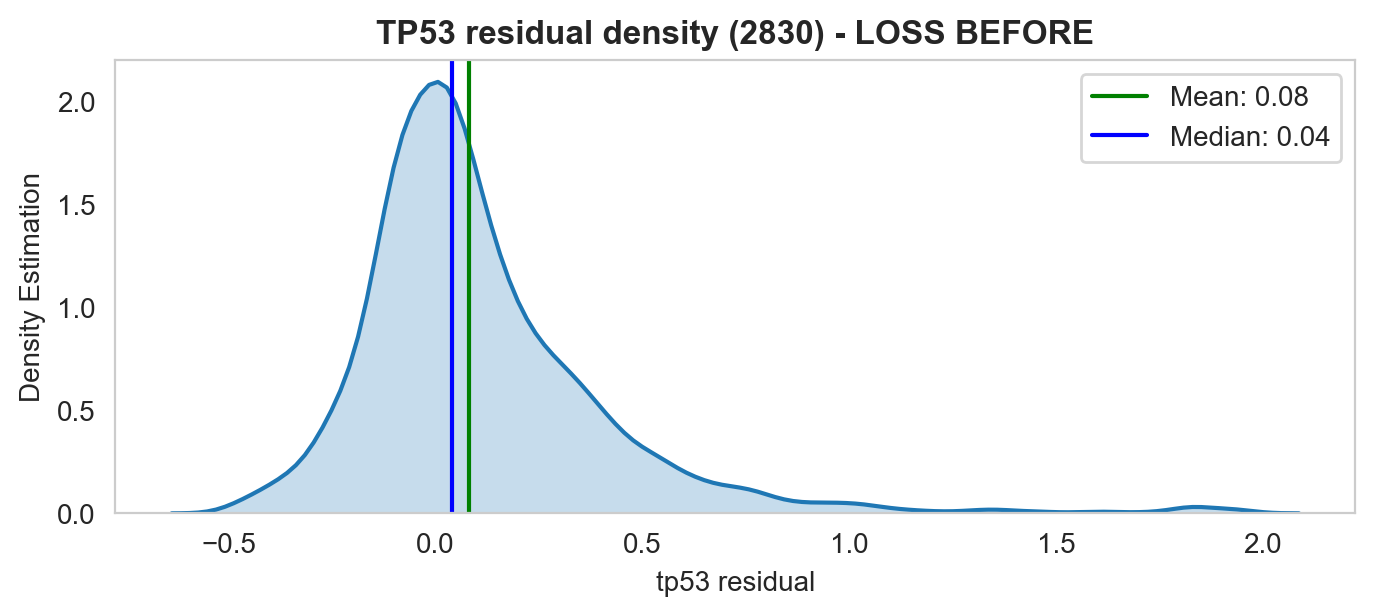

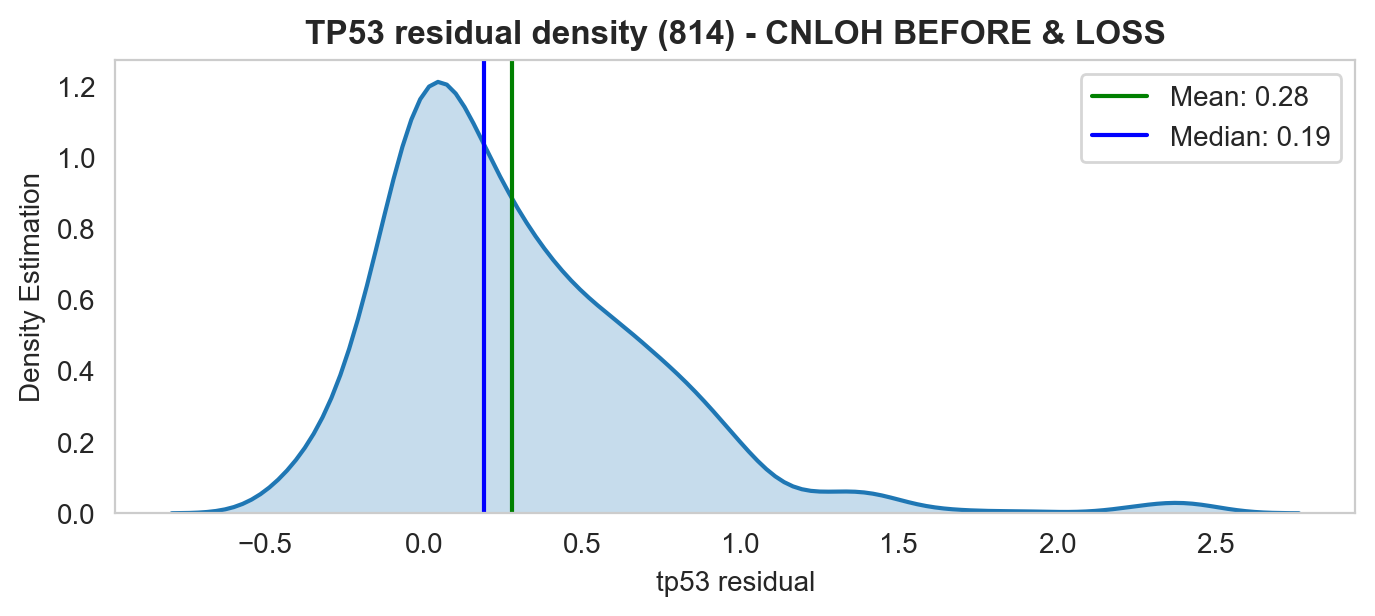

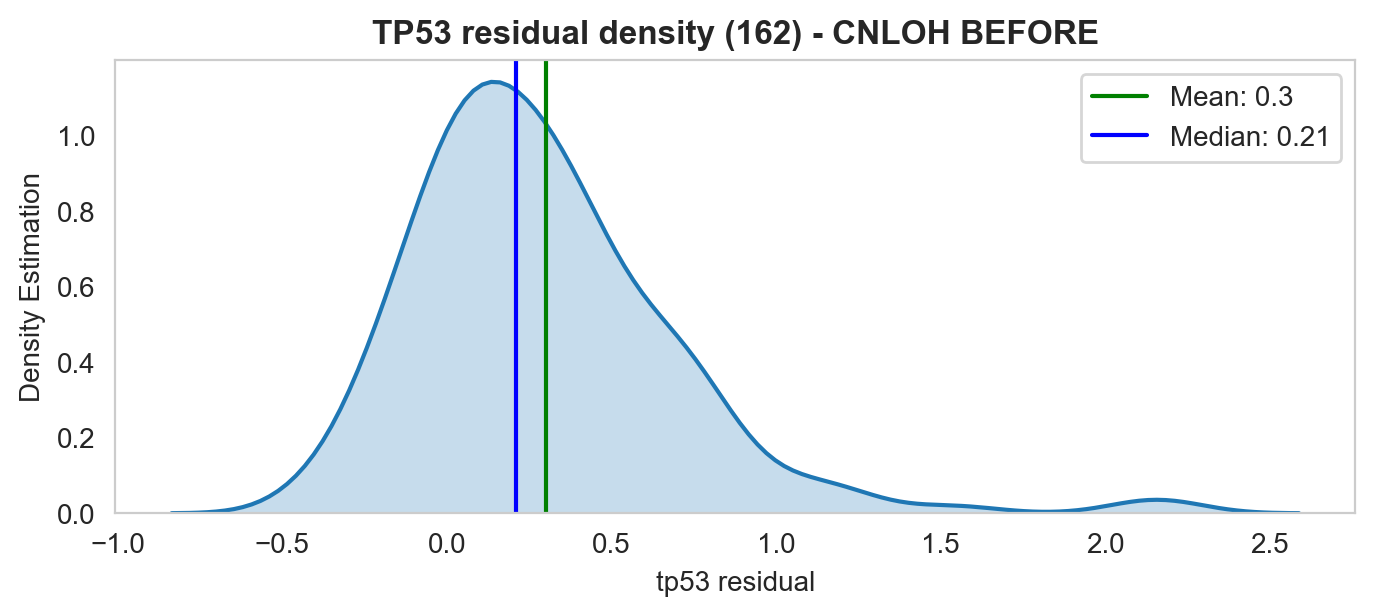

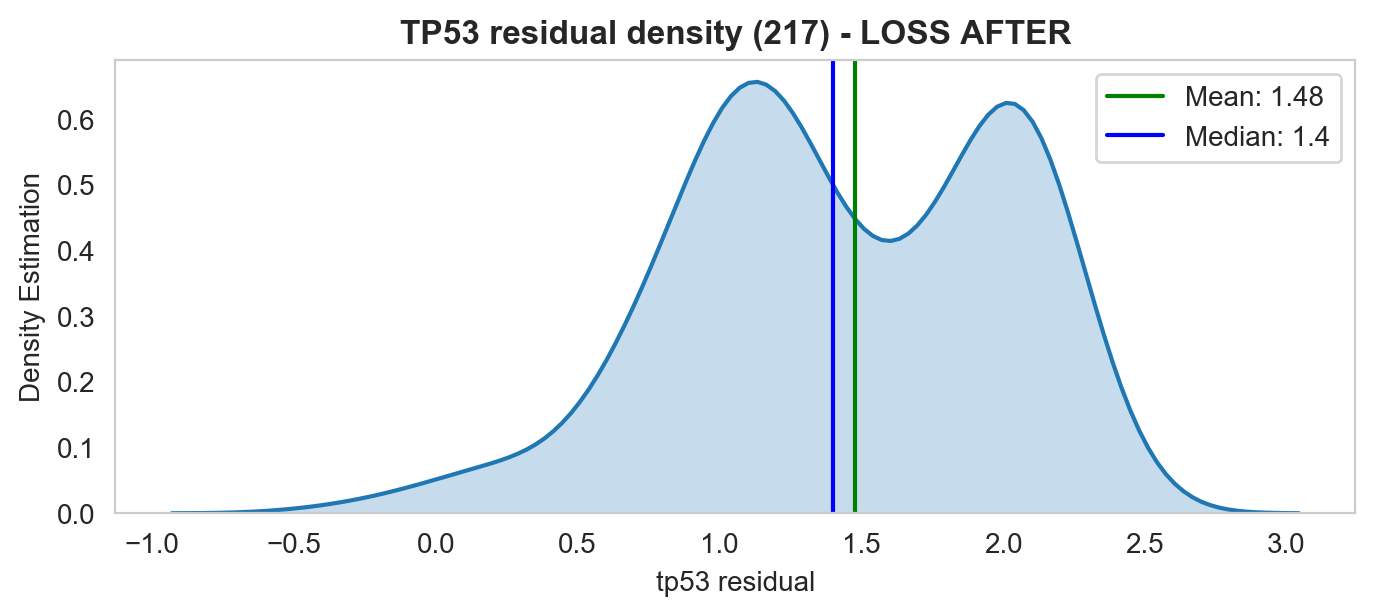

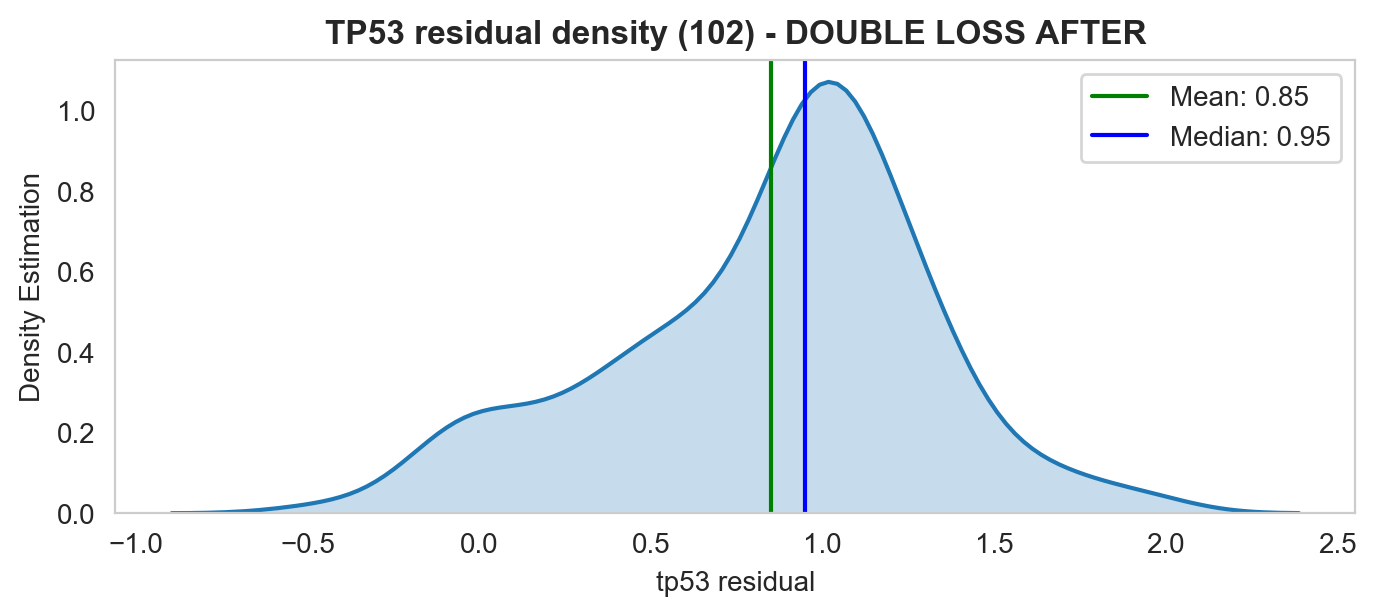

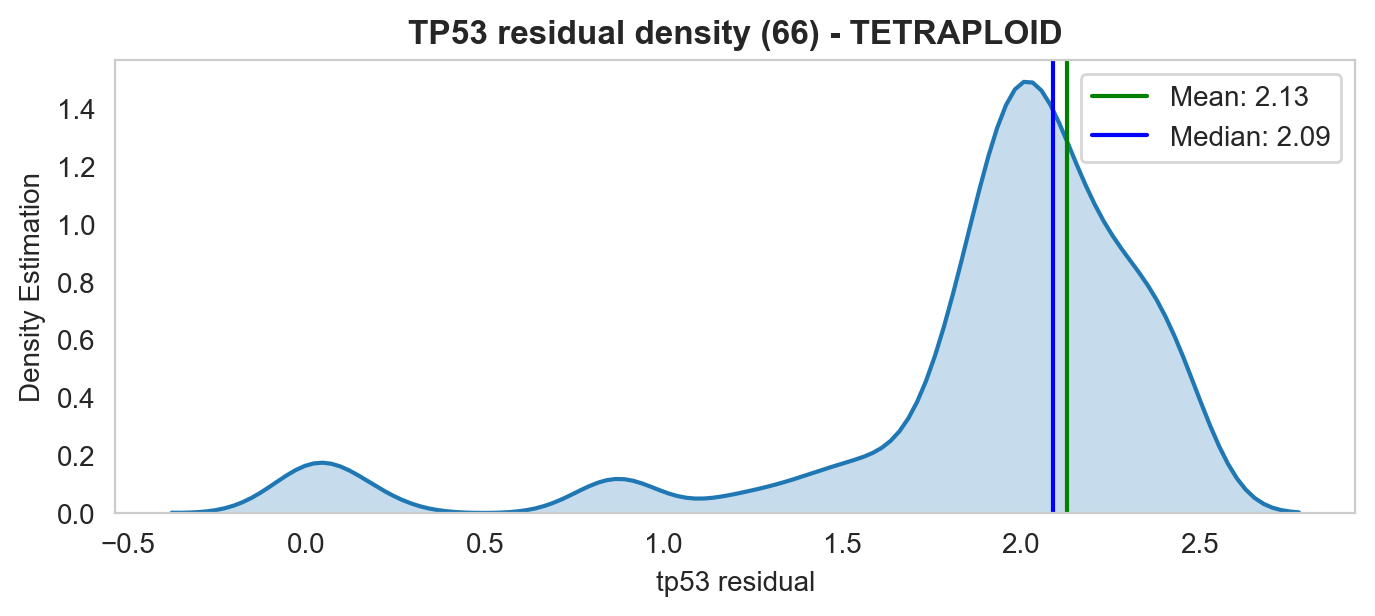

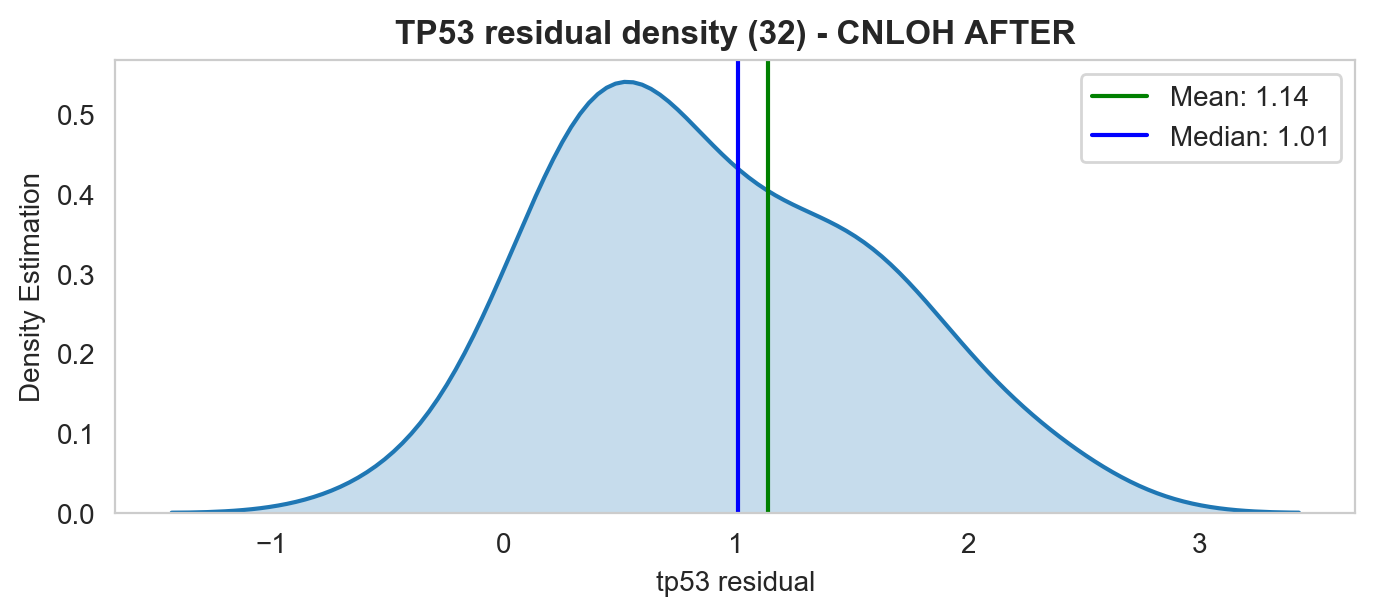

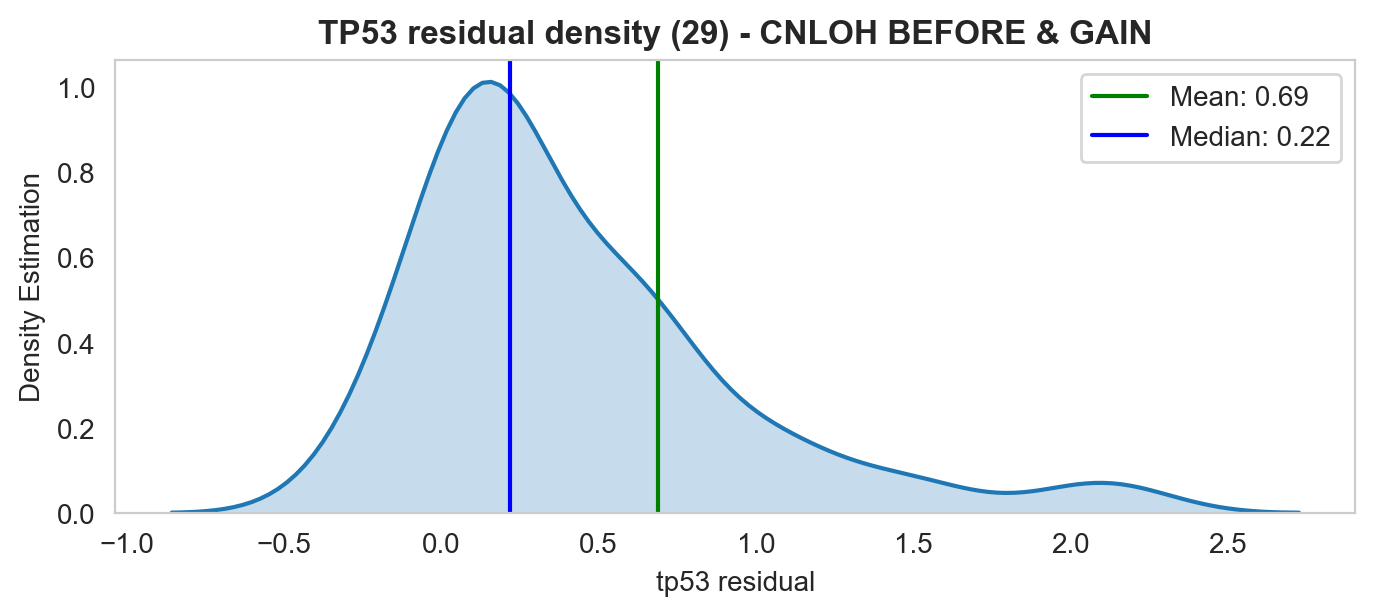

'\n\n            NUMBER OF TP53 residual ASSOCIATED WITH ALLELIC STATE BEFORE WGD\n            \n            \n                                     BI-ALLELIC | MONO - ALLELIC | 2WT\n\n                LOSS BEFORE :            0      |        1       | -\n                CNLOH BEFORE & LOSS:     0      |       1,2      | 2\n                CNLOH BEFORE:            0      |        2       | 3\n                LOSS AFTER:              -      |       1,2      | 2\n                DOUBLE LOSS AFTER:       -      |       0,1      | 1\n                TETRAPLOID:              -      |        2       | 3\n                CNLOH AFTER:             -      |       1,3      | 3\n                CNLOH BEFORE & GAIN:     0      |        2,3     | 3,4\n                \n\n                        THRESHOLDS BETWEEN ALLELIC STATES BEFORE WGD\n                    \n                                     BI-ALLELIC | MONO - ALLELIC | 2WT\n\n                LOSS BEFORE :            <0.4   |        >0.6    | 

In [79]:
for group in ['LOSS BEFORE', 'CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'LOSS AFTER', 'DOUBLE LOSS AFTER',
             'TETRAPLOID', 'CNLOH AFTER', 'CNLOH BEFORE & GAIN']:
    plot_density(xlabel='tp53 residual', 
             ylabel='Density Estimation', 
             title=' - ' + group, 
             clip=(-0.5,2.5),
             group = group,  
             figsize=(8,3))
    
'''

            NUMBER OF TP53 residual ASSOCIATED WITH ALLELIC STATE BEFORE WGD
            
            
                                     BI-ALLELIC | MONO - ALLELIC | 2WT

                LOSS BEFORE :            0      |        1       | -
                CNLOH BEFORE & LOSS:     0      |       1,2      | 2
                CNLOH BEFORE:            0      |        2       | 3
                LOSS AFTER:              -      |       1,2      | 2
                DOUBLE LOSS AFTER:       -      |       0,1      | 1
                TETRAPLOID:              -      |        2       | 3
                CNLOH AFTER:             -      |       1,3      | 3
                CNLOH BEFORE & GAIN:     0      |        2,3     | 3,4
                

                        THRESHOLDS BETWEEN ALLELIC STATES BEFORE WGD
                    
                                     BI-ALLELIC | MONO - ALLELIC | 2WT

                LOSS BEFORE :            <0.4   |        >0.6    | -
                CNLOH BEFORE & LOSS:     <0.4   |      0.6< <1.5 | uncertain
                CNLOH BEFORE:            <1.5   |   1.5< <2.5    | >2.5
                LOSS AFTER:              -      |      <1.5      | uncertain 
                DOUBLE LOSS AFTER:       -      |       <0.5     | uncertain
                TETRAPLOID:              -      |       <2.5     | >2.5
                CNLOH AFTER:             -      |       <1.5     | uncertain
                CNLOH BEFORE & GAIN:     <1.4   |   1.6< <2.5    | uncertain
                
    

 '''

# Saving different cohort files
We want to create 2 master files: one for the WGD cohort, and one for the non WGD cohort.

For that purpose we save the 4 filtered files in 2 different directories:
* '../../../data/impact-facets-tp53/procesed/wgd'
* '../../../data/impact-facets-tp53/procesed/no_wgd'

## Non WGD cohort

In [115]:
# We filter only Non WGD Samples
cohort_nowgd = cohort[cohort['wgd'] == False]

# We store tumor sample ids and matched normal sample ids to filter gene_level anf maf_cohort
samples_nowgd = list(set(cohort_nowgd.tumor_sample))
samples_matched_nowgd = list(set(cohort_nowgd.sample_id))

# now we create:

# maf_cohort
maf_cohort_nowgd = removing_germ_na_mut(maf_cohort[maf_cohort['Tumor_Sample_Barcode'].isin(samples_nowgd)])

#cohort_nowgd = cohort_nowgd[cohort_nowgd.tumor_sample.isin(samples_nowgd)]

#gene_level file
gene_level_nowgd = gene_level[gene_level['sample'].isin(samples_matched_nowgd)]

#arm_level file
arm_level_nowgd = arm_level[arm_level['sample'].isin(samples_matched_nowgd)]

In [116]:
# We just check that we have the same amount of samples in each
assert (len(set(maf_cohort_nowgd.Tumor_Sample_Barcode)) == len(samples_nowgd))
assert(len(set(gene_level_nowgd['sample'])) == len(samples_nowgd))
assert(len(set(arm_level_nowgd['sample'])) == len(samples_nowgd))
print(len(samples_nowgd))

AssertionError: 

In [118]:
# Save the files
nowgd_path = '../../../data/impact-facets-tp53/processed/no_wgd/'
cohort_nowgd.to_csv(nowgd_path + 'cohort_nowgd.txt', sep='\t')
maf_cohort_nowgd.to_csv(nowgd_path + 'maf_cohort_nowgd.txt', sep='\t')
gene_level_nowgd.to_csv(nowgd_path + 'gene_level_nowgd.txt', sep='\t')
arm_level_nowgd.to_csv(nowgd_path + 'arm_level_nowgd.txt', sep='\t')

## WGD cohort

In [119]:
# We filter only Non WGD Samples
cohort_wgd = cohort[cohort['wgd'] == True]

# We store tumor sample ids and matched normal sample ids to filter gene_level anf maf_cohort
samples_wgd = list(set(cohort_wgd.tumor_sample))
samples_matched_wgd = list(set(cohort_wgd.sample_id))

# now we create:

# maf_cohort (we remove NA and GERMLINE mutations)
maf_cohort_wgd = removing_germ_na_mut(maf_cohort[maf_cohort['Tumor_Sample_Barcode'].isin(samples_wgd)])

#samples_wgd = list(set(maf_cohort_wgd.Tumor_Sample_Barcode))

#cohort_wgd = cohort_wgd[cohort_wgd.tumor_sample.isin(samples_wgd)]


#gene_level file
gene_level_wgd = gene_level[gene_level['sample'].isin(samples_matched_wgd)]

#arm_level file
arm_level_wgd = arm_level[arm_level['sample'].isin(samples_matched_wgd)]

In [120]:
# We just check that we have the same amount of samples in each
assert (len(set(maf_cohort_wgd.Tumor_Sample_Barcode)) == len(samples_wgd))
assert(len(set(gene_level_wgd['sample'])) == len(samples_wgd))
assert(len(set(arm_level_wgd['sample'])) == len(samples_wgd))
print(len(samples_wgd))

AssertionError: 

In [123]:
# Save the files
wgd_path = '../../../data/impact-facets-tp53/processed/wgd/'

cohort_wgd.to_csv(wgd_path + 'cohort_wgd.txt', sep='\t')
maf_cohort_wgd.to_csv(wgd_path + 'maf_cohort_wgd.txt', sep='\t')
gene_level_wgd.to_csv(wgd_path + 'gene_level_wgd.txt', sep='\t')
arm_level_wgd.to_csv(wgd_path + 'arm_level_wgd.txt', sep='\t')

# Tests

In [59]:
# test to count the number of mutations per sample
sample_muts = maf_cohort_wgd[maf_cohort_wgd.Tumor_Sample_Barcode == 'P-0025956-T01-IM6'][maf_cohort_wgd.Tumor_Sample_Barcode == 'P-0023546-T02-IM6'][maf_cohort['Hugo_Symbol'] == 'TP53'].drop_duplicates(subset='sample_mut_key')
sample_muts.shape[0]

0

In [54]:
maf_cohort_wgd[maf_cohort_wgd.Tumor_Sample_Barcode == 'P-0023546-T02-IM6'][maf_cohort_wgd.Tumor_Sample_Barcode == 'P-0023546-T02-IM6']

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND_VEP,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,flanking_bps,variant_id,variant_qual,ExAC_AF_Adj,ExAC_AC_AN_Adj,ExAC_AC_AN,ExAC_AC_AN_AFR,ExAC_AC_AN_AMR,ExAC_AC_AN_EAS,ExAC_AC_AN_FIN,ExAC_AC_AN_NFE,ExAC_AC_AN_OTH,ExAC_AC_AN_SAS,ExAC_FILTER,Caller,is-a-hotspot,is-a-3d-hotspot,mutation_effect,oncogenic,LEVEL_1,LEVEL_2A,LEVEL_2B,LEVEL_3A,LEVEL_3B,LEVEL_4,LEVEL_R1,LEVEL_R2,LEVEL_R3,Highest_level,citations,driver,tcn,lcn,cf,purity,t_var_freq,expected_alt_copies,ccf_Mcopies,ccf_Mcopies_lower,ccf_Mcopies_upper,ccf_Mcopies_prob95,ccf_Mcopies_prob90,ccf_1copy,ccf_1copy_lower,ccf_1copy_upper,ccf_1copy_prob95,ccf_1copy_prob90,ccf_expected_copies,ccf_expected_copies_lower,ccf_expected_copies_upper,ccf_expected_copies_prob95,ccf_expected_copies_prob90,facets_fit,reviewer_set_purity,use_only_purity_run,use_edited_cncf,cncf_file_used,LOH
111,CTNNB1,1499,MSKCC,GRCh37,3,41266098,41266098,+,Missense_Mutation,SNP,A,A,C,novel,NaN,P-0023546-T02-IM6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,SOMATIC,NaN,NaN,NaN,MSK-IMPACT,NaN,NaN,NaN,NaN,c.95A>C,p.Asp32Ala,p.D32A,ENST00000349496,3/15,386.0,339.0,47.0,390,390,0,"CTNNB1,missense_variant,p.Asp32Ala,ENST00000349496,NM_001904.3;CTNNB1,missense_variant,p.Asp32Ala,ENST00000396185,NM_001098209.1;CTNNB1,missense_variant,p.Asp32Ala,ENST00000396183,NM_001098210.1;CTNNB1,missense_variant,p.Asp25Ala,ENST00000453024,;CTNNB1,missense_variant,p.Asp32Ala,ENST00000405570,;CTNNB1,missense_variant,p.Asp32Ala,ENST00000450969,;CTNNB1,missense_variant,p.Asp32Ala,ENST00000431914,;CTNNB1,missense_variant,p.Asp32Ala,ENST00000441708,;CTNNB1,missense_variant,p.Asp25Ala,ENST00000426215,;CTNNB1,downstream_gene_variant,,ENST00000433400,;CTNNB1,non_coding_transcript_exon_variant,,ENST00000488914,;,regulatory_region_variant,,ENSR00000203589,;",C,ENSG00000168036,ENST00000349496,Transcript,missense_variant,375/3729,95/2346,32/781,D/A,gAc/gCc,NaN,1,NaN,1,CTNNB1,HGNC,2514.0,protein_coding,YES,CCDS2694.1,ENSP00000344456,P35222,"G9GAG7,E9PDF9,E7EV28,E7EMJ5,C9IZ65,B4DGU4",UPI000012862F,NM_001904.3,deleterious(0),probably_damaging(0.959),3/15,NaN,"hmmpanther:PTHR23315,hmmpanther:PTHR23315:SF53",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,GAC,.,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,Gain-of-function,Likely Oncogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15829978,True,6.0,3.0,0.312907,0.312907,0.121762,1.0,0.422,0.357,0.493,2.583183e-13,1.732627e-11,1.000,0.944,1.000,0.545539,0.816613,1.000,0.944,1.000,0.545539,0.816613,/juno/work/ccs/shared/resources/impact/facets/all/P-00235/P-0023546-T02-IM6_P-0023546-N01-IM6//default,NaN,False,False,/juno/work/ccs/shared/resources/impact/facets/all/P-00235/P-002354

In [125]:
# We will merge maf_cohort and gene_level in order to count the samples that have at least one tp53 event (either
# tp53 mutation or tp53 CN event)
# We add the WGD information to know if DIPLOID or TETRAPLOID is our baseline in terms of tp53 CN

# First we select the columns
maf_cohort_merge = maf_cohort_wgd[['Tumor_Sample_Barcode', 'Hugo_Symbol']]
gene_level_merge = gene_level_tp53_wgd[['tumor_id', 'cn_state']]
cohort=cohort[['tumor_sample', 'wgd']]

# We merge
tp53_hit = pd.merge(maf_cohort_merge, gene_level_merge, how='left', left_on='Tumor_Sample_Barcode', right_on='tumor_id')
tp53_hit = pd.merge(tp53_hit, cohort, how='left', left_on='Tumor_Sample_Barcode', right_on='tumor_sample')


In [126]:
tp53_hit.columns = ['tumor_id', 'Hugo_Symbol', 'tumor_id_bis', 'tp53_cn_state', 'tumor_id_ter', 'wgd']
tp53_hit = tp53_hit.drop(['tumor_id_bis', 'tumor_id_ter'], axis=1)

,tumor_id,Hugo_Symbol,tp53_cn_state,wgd
0,P-0025956-T01-IM6,KRAS,LOSS AFTER,True
1,P-0025956-T01-IM6,STK11,LOSS AFTER,True
2,P-0025956-T01-IM6,KEAP1,LOSS AFTER,True
3,P-0025956-T01-IM6,SMARCA4,LOSS AFTER,True
4,P-0025956-T01-IM6,PTPRT,LOSS AFTER,True
...,...,...,...,...
90473,P-0049537-T01-IM6,ELF3,HETLOSS,True
90474,P-0049537-T01-IM6,KRAS,HETLOSS,True
90475,P-0049537-T01-IM6,TP53,HETLOSS,True
90476,P-0049537-T01-IM6,RNF43,HETLOSS,True


In [45]:
master = pd.read_pickle(data_path + 'merged_data/master_file.pkl')
# We eliminate unmatched samples
master = master[master['Somatic_Status']!='Unmatched']
#We eliminate samples with too low purity
samples_cutoff = list(master[master['purity'] > 0.20]['Tumor_Id'])
samples_na = list(master[master['purity'].isna()]['Tumor_Id'])
samples_cutoff = samples_cutoff + samples_na
master_cutoff = master[master.Tumor_Id.isin(samples_cutoff)]